In [32]:
# Librerías necesarias:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, make_scorer, roc_auc_score,auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector,f_classif

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

## Preprocesado de datos

In [2]:
database= pd.read_csv("database_preprocesada.csv")                           # Cargamos la base de datos

nombres_variables = database.columns.tolist()                                # Mostramos todas las variables disponibles de nuestro database
num_observaciones, num_variables = database.shape                            # Mostramos el tamaño


print(f"Variables de nuestro database: {', '.join(nombres_variables)}\n"            # Join sirve para poner todo en una linea
      f"Número de variables: {num_variables}\n"
      f"Número de observaciones: {num_observaciones}\n"                                                 
      "Tipos de cada variable: " + ", ".join([f"{col}: {dtype}" for col, dtype in database.dtypes.items()]))     # Imprimimos los tipos también

Variables de nuestro database: Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age, Education, Income
Número de variables: 22
Número de observaciones: 253680
Tipos de cada variable: Diabetes_012: float64, HighBP: float64, HighChol: float64, CholCheck: float64, BMI: float64, Smoker: float64, Stroke: float64, HeartDiseaseorAttack: float64, PhysActivity: float64, Fruits: float64, Veggies: float64, HvyAlcoholConsump: float64, AnyHealthcare: float64, NoDocbcCost: float64, GenHlth: float64, MentHlth: float64, PhysHlth: float64, DiffWalk: float64, Sex: float64, Age: float64, Education: float64, Income: float64


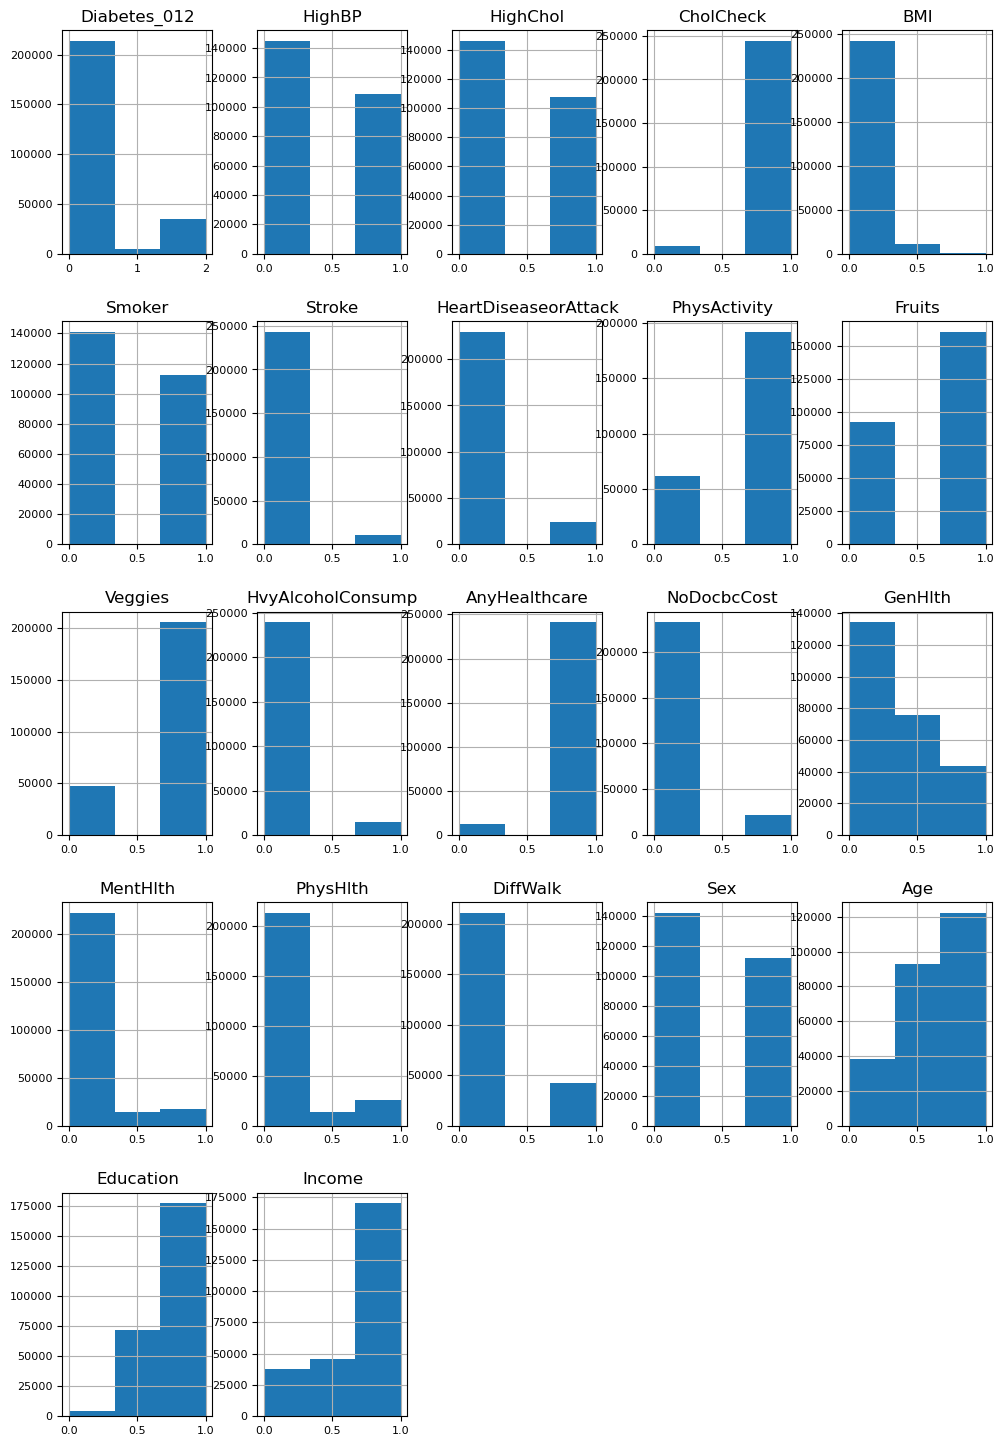

In [3]:
database.hist(figsize=(12,18), bins=3, xlabelsize=8, ylabelsize=8)
plt.axis('off')
plt.show()

Como podemos observar, ya tenemos todas nuestras variables normalizadas.

Nuestra variable target es Diabetes_012, que es una variable categórica de 3 clases donde:

-0: Paciente sano

-1: Prediabético

-2: Diabético

Está bastante desbalanceada, como se puede observar.


In [4]:
# Contamos el número de observaciones de cada valor en 'target'
value_counts = database['Diabetes_012'].value_counts()

# Calculamos la proporción respecto al total
proportions = value_counts / len(database) * 100

categories= ['Sanos, Diabéticos, No diabéticos'] 
# Mostramos los resultados con proporción
result = pd.DataFrame({
    'Nº de observaciones': value_counts,
    'Proporción (%)': proportions
})

# Ajustamos la visualización con pandas Styler
result = result.style.set_properties(**{'text-align': 'center'}) \
                             .set_table_styles([{
                                 'selector': 'th',
                                 'props': [('text-align', 'center')]
                             }])
result

,Nº de observaciones,Proporción (%)
Diabetes_012,,
0.000000,213703,84.241170
2.000000,35346,13.933302
1.000000,4631,1.825528


- Vemos si hay missing values:

In [5]:
valores_perdidos=database.isnull().values.any()   # Este codigo devuelve True si hay valores reconocidos como Nul o NaN

if valores_perdidos:
    print("Hay valores perdidos")
    database.isnull().sum()           # Mostraría el número de valores perdidos por columna en el dataset.
else:
     print("No hay valores perdidos")

No hay valores perdidos


- Tamaño de nuestra base de datos:

A lo largo del proyecto nos hemos encontrado con muchos problemas en cuanto al tiempo de ejecución (mas de 10 minutos por cada modelo). Esto es debido al gran número de muestras (253680) y de características (22) que tenemos en nuestra base de datos. Las soluciones a esto pueden ser:

- Reducir el tamaño del conjunto de datos.
- Entrenamiento en paralelo (ya implementado con n_jobs=-1).
- Optimización de los algoritmos con técnicas como early-stopping.

Hemos optado a reducir el tamaño del conjunto de datos, aprovechando el hecho de que disponemos de clases muy desbalanceadas. Por ello, hemos optado por hacer un submuestreo de la clase mayoritaria (Undersampling) en un mayor porcentaje,  y algo de la clase intermedia y asi no perdemos mucha información crucial. 

In [6]:
X = database.drop(['Diabetes_012'], axis = 1)       # Extraemos de las variables de entrada nuestra variable target
Y = database['Diabetes_012']                        # Declaramos Diabetes_012 como variable de salida

# Aplicamos el submuestreo para ajustar la proporción
total_samples= num_observaciones

# Establecemos los porcentajes deseados para nuestras clases que pretendemos reducir
healthy_samples = 100000                                            

diab_middle_samples = 27500

prediab_samples= 4631

# Establecer el número de muestras que queremos para cada clase
sampling_strategy = {
    0: healthy_samples,                 # Para la clase mayoritaria
    2: diab_middle_samples,             # Para la clase intermedia reducir un poco
    1: prediab_samples                  # Para la clase minoritaria, mantener el tamaño original
}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X,Y)

# Verificar la distribución después del submuestreo
resampled_counts = pd.Series(y_resampled).value_counts()

# Calculamos la proporción respecto al total
proportions = resampled_counts/ len(X_resampled) * 100

categories= ['Sanos, Diabéticos, No diabéticos'] 

# Mostramos los resultados con proporción
result = pd.DataFrame({
    'Nº de observaciones': resampled_counts,
    'Proporción (%)': proportions
})

# Ajustamos la visualización con pandas Styler
result = result.style.set_properties(**{'text-align': 'center'}) \
                             .set_table_styles([{
                                 'selector': 'th',
                                 'props': [('text-align', 'center')]
                             }])
result

,Nº de observaciones,Proporción (%)
Diabetes_012,,
0.000000,100000,75.682467
2.000000,27500,20.812678
1.000000,4631,3.504855


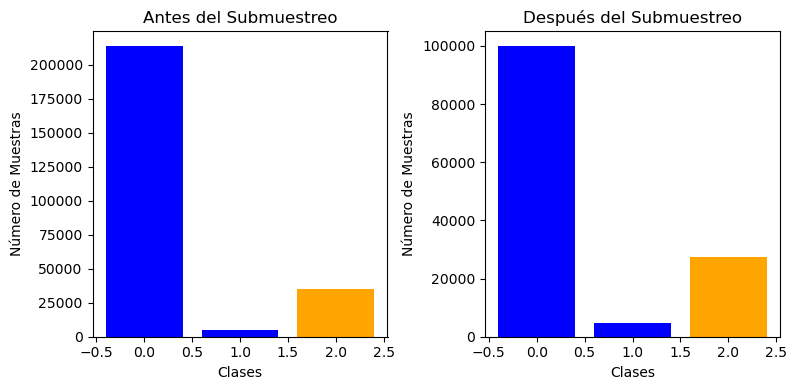

In [7]:
# Visualizar la distribución antes y después
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Antes del submuestreo
ax[0].bar(value_counts.index, value_counts.values, color=['blue', 'orange'])
ax[0].set_title("Antes del Submuestreo")
ax[0].set_xlabel("Clases")
ax[0].set_ylabel("Número de Muestras")

# Después del submuestreo
ax[1].bar(resampled_counts.index, resampled_counts.values, color=['blue', 'orange'])
ax[1].set_title("Después del Submuestreo")
ax[1].set_xlabel("Clases")
ax[1].set_ylabel("Número de Muestras")

plt.tight_layout()
plt.show()

Podemos observar que la clase mayoritaria sigue siendolo,por lo que, no hemos perdido mucha información, pero hemos podido reducir a mas de la mitad el numero de muestras.

- Separamos nuesta base de datos en el conjunto de entrenamiento vs test.

In [8]:
# Separamos el conjunto de diseño (X_train, y_train) en un 70% y de test (X_test, y_test) en un 30% :
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state=2)

In [9]:
# Contamos el número de observaciones de cada valor en 'target'
value_counts_train = pd.Series(y_train).value_counts()
value_counts_test = pd.Series(y_test).value_counts()

# Calculamos la proporción respecto al total
proportions_train = value_counts_train / len(database) * 100
proportions_test= value_counts_test / len(database) * 100

categories= ['Sanos, Diabéticos, No diabéticos'] 
# Mostramos los resultados con proporción
result = pd.DataFrame({
    'Nº de observaciones_train': value_counts_train,
    'Proporción Train (%)': proportions_train,
    'Nº de observaciones_test': value_counts_test,
    'Proporción Test (%)': proportions_test,
})

# Ajustamos la visualización con pandas Styler
result = result.style.set_properties(**{'text-align': 'center'}) \
                             .set_table_styles([{
                                 'selector': 'th',
                                 'props': [('text-align', 'center')]
                             }])
result

,Nº de observaciones_train,Proporción Train (%),Nº de observaciones_test,Proporción Test (%)
Diabetes_012,,,,
0.000000,69830,27.526805,30170,11.892936
2.000000,19408,7.650583,8092,3.189845
1.000000,3253,1.282324,1378,0.543204


# **Tema 4 – Métodos no paramétricos**


Puesto que los esquemas no paramétricos presentados en este tema se pueden utilizar para resolver.
una tarea de clasificación o una tarea de regresión, cada grupo elegirá una variable target (en principio, uni-dimensional a no ser que el conjunto de datos especifique otra cosa) que le permita
abordar una de estas dos tareas (a elegir por el grupo). Se sugiere abordar esta tarea utilizando el esquema de los k vecinos más próximos, árboles de clasificación/regresión, perceptrón multicapa (considerado red neuronal artificial) y un esquema ensemble como Random Forest o Gradient
Boosting.

En el desarrollo de los siguientes esquemas debe utilizar siempre la misma partición de
observaciones asociadas al conjunto de test. Ello le permitirá realizar comparaciones justas (fair)
entre las distintas aproximaciones.

**Explique detalladamente (no es necesario que lo implemente) qué podría hacer si no dispusiera de partición de test y quisiera estimar la capacidad de generalización estando “suficientemente seguro” de que las características elegidas son las más adecuadas para abordar la tarea.**

Para poder estimar la capacidad de generalización sin hacer la partición de test tenemos diferentes métodos, entre los que destaca:

- Validacion cruzada: Consiste en dividir el conjunto de datos en varias particiones (llamadas "folds") y entrenar el modelo múltiples veces, utilizando cada partición como conjunto de validación y las restantes como conjunto de entrenamiento. Las siguientes son algunas variantes:

    - K-Fold Cross-Validation:

    El conjunto de datos se divide en *K* particiones de tamaño aproximadamente igual. Se entrena el modelo *K* veces, cada vez utilizando una partición diferente como conjunto de validación y el resto como conjunto de entrenamiento.

    El rendimiento del modelo se promedia sobre las *K* iteraciones.

    - Leave-One-Out Cross-Validation (LOOCV):

    Cada instancia del conjunto de datos se utiliza una vez como conjunto de validación, mientras que el resto se utiliza como conjunto de entrenamiento.

    Este método es muy exhaustivo, pero puede ser costoso computacionalmente para conjuntos de datos grandes.

Otros métodos son el Bootstrap Sampling y la Evaluación In-Sample y Métricas Derivadas.

## **a) Esquema k-nn**

- Explique el significado del hiper-parámetro k. ¿Cómo se estima el valor del target de una determinada observación de test al aplicar el esquema k-nn?

  El hiperparámetro k determina el número de vecinos más próximos a considerar para clasificar un observación a una clase. Para estimar el valor del target:
  - Calcular la distancia
  - Identificar los k vecinos más cercanos
  - Estimar el valor del target:
    - Para regresión: Se calcula la media o la mediana del valor del target de los k vecinos más cercanos. Este valor se utiliza como la estimación del      valor del target para la observación de test.
    - Para clasificación: Se asigna a la observación de test la clase más frecuente entre sus k vecinos más cercanos.
      

- ¿Cómo puede encontrar el valor del hiper-parámetro k más adecuado a un conjunto de observaciones?

  Una métrica que nos ayuda a saber el mejor valor del hiper-parámetro es la tasa de error en el conjunto de validación. Nos fijamos en los valores mas bajos, antes de que la tasa de error pueda volver a subir. Ante valores de tasa de error iguales, se elige la k más baja por el principio de parsimonia.

- Discuta razonadamente la relación entre la capacidad de generalización y el valor del hiper-parámetro k.

  A valores más altos de k, se pierde flexibilidad en la frontera por lo que la capacidad de generalización es mayor. La contraindicación es que llega un momento que la tasa de error puede volver a subir.

- Suponga que se ha utilizado un esquema k−nn con una base de datos en la que no ha normalizado las características. Indique si las prestaciones obtenidas cambiarían si el diseño y la evaluación de prestaciones se realizara con las variables normalizadas.
Justifique su respuesta.

  Si que cambiarían las prestaciones. Al no normalizar las características y ser un algoritmo que se basa en la distanmcia entre las observaciones, si tenemos características con un rango más amplio van a dominar más el resultado frente a  otras.

- Explore varios valores del hiper-parámetro k e indique razonadamente qué valor de k elegiría. Incluya en el proyecto una o varias gráficas que muestren al menos la evolución de dos figuras de mérito diferentes (útiles en la tarea a resolver) para cada valor de k explorado. Teniendo en cuenta esta información, justifique la elección de un único valor de k.

Vamos a hacer un KNN clasificador, ya que nuestra salidad es una variable categórica.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tiempo de ejecución del clasificador k-NN: 2.6248 minutos
Valores de AUC para cada valor de k:
k          Train AUC  Val AUC    Change %  
1          0.9935     0.5743     57.4317   
11         0.8609     0.6928     11.8437   
21         0.8306     0.7137     2.0918    
31         0.8155     0.7251     1.1393    
41         0.8053     0.7304     0.5323    
51         0.7980     0.7340     0.3636    
61         0.7925     0.7363     0.2316    
71         0.7878     0.7369     0.0535    
81         0.7846     0.7379     0.1032    
91         0.7819     0.7394     0.1473    


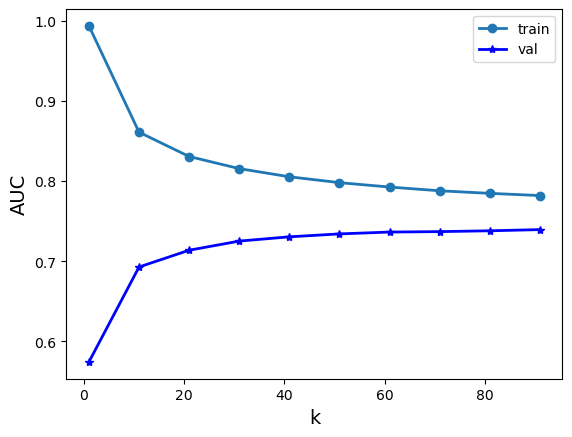

Mayor AUC en validación: 0.739
Valor correspondiente para el hiperparámetro: {'n_neighbors': 91}


In [268]:
# Seleccionamos del hiper-parámetro k en una secuencia de 1 a 40 en paso de 2.
param_grid = {'n_neighbors': range(1,101,10)}
k_grid = param_grid['n_neighbors']                  # Extraemos los valores del eje x

# GridSearch nos ayuda a buscar el mejor valor de k
grid_search = GridSearchCV(
    KNeighborsClassifier(),                         # Modelo: K-Nearest Neighbors (KNN).
    param_grid=param_grid,     	                    # Rango de valores para el hiperparámetro 'k' (n_neighbors).
    cv=3,                                           # Número de particiones (folds) para validación cruzada.
    scoring='roc_auc_ovr',                          # Métrica a optimizar: AUC con enfoque One-vs-Rest (multiclase).
    error_score='raise',       	                    # Si ocurre un error, lo reporta en lugar de ignorarlo.
    return_train_score=True,                        # Devuelve las métricas del conjunto de entrenamiento además de validación.
    verbose=1,                                      # Muestra información del progreso.
    n_jobs=-1                                       # Usa todos los núcleos disponibles para acelerar el procesamiento.
)

# Medimos el tiempo de ejecución
start_time = time.time()  # Tiempo de inicio

# Entrenamiento del GridSearch con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Tiempo de finalización
end_time = time.time()  

# Calculamos y mostramos el tiempo total
execution_time = (end_time - start_time)/60
print(f"Tiempo de ejecución del clasificador k-NN: {execution_time:.4f} minutos")

# Extraemos las métricas AUC promedio para cada valor de k desde los resultados del GridSearch
auc_knn_train = np.array(grid_search.cv_results_['mean_train_score'])  # AUC promedio en el conjunto de entrenamiento.
auc_knn_val = np.array(grid_search.cv_results_['mean_test_score'])     # AUC promedio en el conjunto de validación.


# Mostramos los valores de AUC obtenidos para cada valor de k
print("Valores de AUC para cada valor de k:")
print(f"{'k':<10} {'Train AUC':<10} {'Val AUC':<10} {'Change %':<10}")

auc_prev=0
for k, auc_train, auc_val in zip(k_grid, auc_knn_train, auc_knn_val):   # Bucle para calcular el cambio
    auc_dif= (auc_val - auc_prev) * 100
    auc_prev=auc_val
    print(f"{k:<10} {auc_train:<10.4f} {auc_val:<10.4f} {auc_dif:<10.4f}")

# Graficamos las curvas de AUC en función de k para entrenamiento y validación
plt.plot(k_grid, auc_knn_train, '-o', label="train", linewidth=2)          # Curva para AUC de entrenamiento.
plt.plot(k_grid, auc_knn_val, '-*b', label="val", linewidth=2)             # Curva para AUC de validación.
plt.xlabel('k', fontsize=14)  
plt.ylabel('AUC', fontsize=14)  
plt.legend()  
plt.show() 

# Mostramos el mejor valor de AUC en validación y el valor óptimo de k correspondiente
print("Mayor AUC en validación: {:.3f}".format(grid_search.best_score_))  # Mejor AUC en validación cruzada.
print("Valor correspondiente para el hiperparámetro: {}".format(grid_search.best_params_))  # Mejor valor de k.

En nuestro caso, se ha hecho un K-nn de clasificación ya que nuestro target (Diabetes_012) es una variable categórica de 3 valores. Al ser un problema multiclase, hemos tenido que introducir en la métrica a optimizar una AUC con enfoque One-vs-Rest (OvR), donde cada clase se trata como una clasificación binaria contra todas las demás clases.

Los resultados obtenidos son buenos, pero no nos podemos fiar de los recomendados por el propio modelo (k=91), ya que aunque los resultados si son los mejores en el conjunto de validación, la diferencia con k previos es muy pequeña. Entre k=20 y k=56 solo ha habido un cambio de aproximadamente un 3% del valor de AUC en el conjunto de validación. 
Es por tanto que, por el principio de parsimonia, hemos escogido el valor de **k=30.**

**Con el valor elegido de k elegido, determine los valores de 4 figuras de mérito para estimar las prestaciones sobre un conjunto de test independiente del utilizado en el diseño. Comente los resultados obtenidos.**

In [284]:
kNN_clasif_all = KNeighborsClassifier(n_neighbors = 30)
modelo_knn_clasif = kNN_clasif_all.fit(X_train, y_train)     # Entrenamos el modelo

y_proba_knn = modelo_knn_clasif.predict_proba(X_test)        # Devolvemos la salida blanda del clasificador
y_output_knn=modelo_knn_clasif.predict(X_test)               # Devolvemos la salida dura

- Roc_Auc

AUC en test de clase No diabético= 0.7885812829726938
AUC en test de clase Prediabético= 0.5687801616674099
AUC en test de clase Diabético= 0.7916935306107318


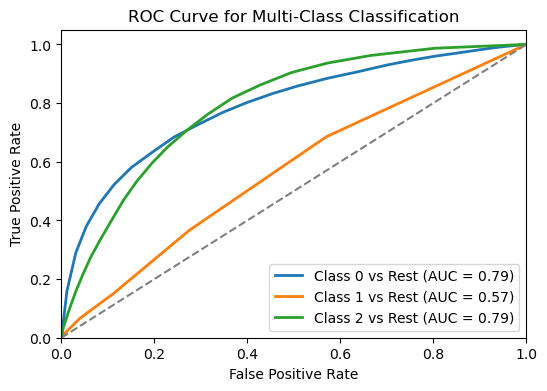

In [285]:
datanames=['No diabético', 'Prediabético', 'Diabético']      # Nombres de las clases
# Binarizar las etiquetas de las clases
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Calcular la curva ROC para cada clase
plt.figure(figsize=(6, 4))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')
    print(f"AUC en test de clase {datanames[i]}= {roc_auc}")
    
# Añadir la línea diagonal (sin discriminación)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Añadir etiquetas y título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')

plt.show()



Podemos observar como el modelo clasifica muy bien para la clase 0 (diabética).La curva ROC muestra un AUC de 0.79. Esto indica que el modelo tiene un buen rendimiento al distinguir la clase 0 del resto de las clases.

La curva ROC de la clase 1 (prediabética) muestra un AUC de 0.59. Este valor sugiere que el modelo tiene un rendimiento mu cercano al azar al identificar a esa clase. No es tan efectivo como en la clasificación de la clase diabética. 

La curva ROC de la clase 2 (diabética) también muestra un AUC de 0.79, similar a la clase 0. Por lo que es capaz de diferenciar esa clase sobre las otras.

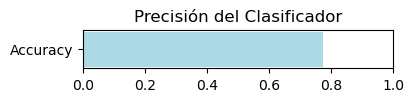

Tasa de acierto en test =  0.7732593340060545


In [286]:
# Visualización de la precisión
accuracy=accuracy_score(y_test, y_output_knn)

plt.figure(figsize=(4, 0.5))
plt.barh(['Accuracy'], [accuracy], color='lightblue')
plt.xlim(0, 1)
plt.title('Precisión del Clasificador')
plt.show()
print("Tasa de acierto en test = ",accuracy)

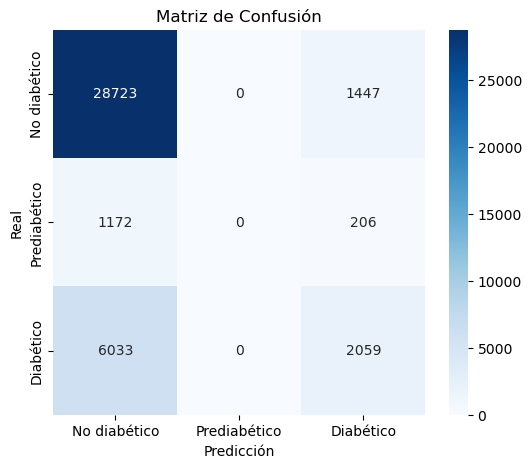

In [283]:
# Visualización de la matriz de confusión 
conf_matrix= confusion_matrix(y_test, y_output_knn)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=datanames, yticklabels=datanames)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Como podemos ver, la matriz de confusión multiclase nos muestra los True Poisitive (TP) y los False Positive (FP) de cada clase, concretando también la clase errada en el caso de los FP.
Se puede observar un error muy claro. Nuestro modelo no predice ningún paciente prediabético. Esto es debido a que es una clase con muy pocas muestras.
En el caso del diabético, no tiene muy buen resultado, pero mejora al azar. Sin embargo, en caso de los pacientes sanos, nuestro modelo es muy preciso clasificandolos.
Visto los resultados, vamos a calcular la precisión por clase:

Accuracy de la clase 0: 0.95
Accuracy de la clase 1: 0.00
Accuracy de la clase 2: 0.25


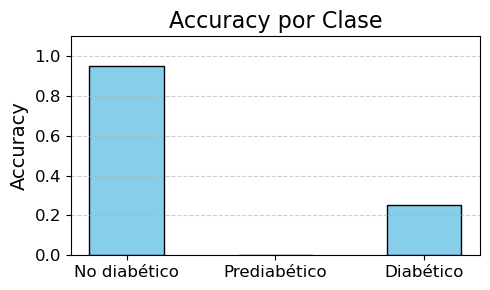

In [287]:
# Calculamos el accuracy por clase
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)   # La diagonal tiene los TP por clase. La suma obtiene todas las observaciones

# Visualizamos el accuracy por clase
for i, acc in enumerate(accuracy_per_class):
    print(f'Accuracy de la clase {i}: {acc:.2f}')

plt.figure(figsize=(5, 3))
bars = plt.bar(datanames, accuracy_per_class, color='skyblue', edgecolor='black',width=0.5)

plt.title('Accuracy por Clase', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # El límite superior para dar espacio a los valores encima de las barras
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Se puede decir que en el caso de los pacientes prediabéticos y diabéticos, nuestro modelo no funciona bien. En el caso de la clase diabética se contraindica a lo obtenido en la métrica AUC. Esto es debido a que hemos calculado la ROC de una clase respecto a las demás, por lo que al no predecir ningún paciente como prediabético su métrica AUC es alta. 

Esto es debido al desbalanceo de clases, ya que,como hemos demostrado, los pacientes prediabéticos solo suponen el 3.8 % de nuestros pacientes y los diabéticos solo un 20%.

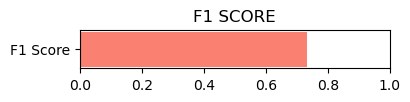

F1-Score (Weighted) del clasificador KNN: 0.734171016901269


In [288]:
# Calcular el F1-Score para el problema multiclase
f1 = f1_score(y_test, y_output_knn, average='weighted')  # 'weighted' calcula el promedio ponderado por la frecuencia de cada clase

# Mostrar el resultado
plt.figure(figsize=(4, 0.5))
plt.barh(['F1 Score'], [f1], color='salmon')
plt.xlim(0, 1)
plt.title('F1 SCORE')
plt.show()

print(f'F1-Score (Weighted) del clasificador KNN: {f1}')

El F1-Score es una métrica de evaluación que balancea la precisión y el recall, especialmente útil cuando se tienen clases desbalanceadas. 
En el caso de clasificación multiclase, es mejor utilizar un F1-score ponderado (promediado según el número de instancias de cada clase). El promedio ponderado asegura que el F1-Score final tenga en cuenta la distribución de las clases.Se puede observar que nuestros resultados son buenos.

Se puede concluir por tanto en vista a las métricas obtenidas, que nuestro modelo en general funciona bastante bien, pero es nulo clasificando a pacientes prediabéticos y da malas prestaciones en los pacientes no diabéticos. Esto es debido al extremo desbalanceo que tenemos en nuestro conjunto de datos.


## **b) Árboles**

- Justifique razonadamente la conveniencia o no de normalizar las características antes de aplicar este esquema de aprendizaje.
  
    No es necesario puesto que las divisiones de árboles se basan en umbrales de decisión de cada característica, donde no juega ningún papel su escala.

- Considerando como punto de partida la regla de bolsillo presentada en las sesiones prácticas de la asignatura*, evalúe los diseños con distintos valores asociados únicamente al hiper-parámetro . Justifique razonadamente los valores explorados. Utilizando sus propias palabras, explique la relación entre el “mínimo número de muestras por nodo hoja” y la profundidad del árbol.

Nota: Ibamos a a mitigiar nuestro desbalanceo de clases, usando el parámetro class_weight 'balanced': que ajusta automáticamente los pesos de las clases inversamente proporcionales a su frecuencia en el conjunto de datos. Pero hemos visto que no mejora las prestaciones.

In [319]:
# Selección de hiper-parámetros del árbol. En este caso es “mínimo número de muestras por nodo hoja”
param_grid = {'min_samples_leaf': range(1,300,10)}                          # Valores a probar

scoring = ['accuracy', 'f1_macro', 'roc_auc_ovr']

grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=42),   # Buscamos el mejor valor para nuestro hipér-parámetro.
                                 param_grid = param_grid,                   
                                 scoring = scoring,                                # Debido a que es clasificación multiclase
                                 refit='f1_macro',
                                 cv=3,
                                 return_train_score=True,     
                                 verbose=1)  

# Medimos el tiempo de ejecución
start_time = time.time()  # Tiempo de inicio

grid_arbol_clasif.fit(X_train, y_train)

# Tiempo de finalización
end_time = time.time()  
execution_time = (end_time - start_time)/60                                        # Calculamos y mostramos el tiempo total
print(f"Tiempo de ejecución del clasificador k-NN: {execution_time:.4f} minutos")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Tiempo de ejecución del clasificador k-NN: 0.5082 minutos


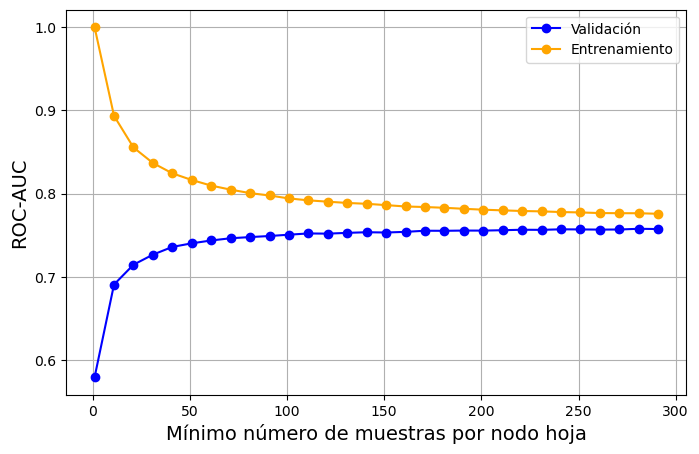

In [291]:
valores_min_leaf=param_grid['min_samples_leaf']

rocauc_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_roc_auc_ovr'])
rocauc_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_roc_auc_ovr'])

plt.figure(figsize=(8,5))
plt.plot(valores_min_leaf,rocauc_val_arbol,marker='o',label="Validación", color='blue')
plt.plot(valores_min_leaf,rocauc_train_arbol,marker='o',label="Entrenamiento", color='orange')
plt.xlabel('Mínimo número de muestras por nodo hoja',fontsize=14)
plt.ylabel('ROC-AUC',fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

El hiperparámetro "minimo número de muestras por hoja" determina el número mínimo de muestras que debe tener un nodo hoja (es decir, un nodo final). Si el nodo tiene menos muestras que este valor, no se dividirá más. Establecer un valor mayor puede hacer que el árbol sea más generalizado, ya que evita particiones muy específicas en los datos.
Establecer un valor menor puede permitir que el árbol sea más complejo, ya que permite una mayor división de los nodos, lo que puede llevar a un sobreajuste (overfitting) en los datos de entrenamiento.
La relación entre el número mínimo de muestras por nodo hoja y la profundida del árbol es inversamente proporcional, ya que cuando aumenta el valor mínimo de muestras por nodo, hace que cada nodo tenga que tener más muestras, por lo que dismininuye la profundidad del árbol.

Debido a nuestro gran tamaño del conjunto de datos, hemos probado con valores bastante altos de este hiperparámetro. Como primera aproximación, vamos a escoger el valor de c=110, ya que el siguiente valor tiene una AUC menor y a partir de ahí los cambios son marginales.

- Indique razonadamente qué valor del hiper-parámetro elegiría. Incluya en el proyecto una o varias gráficas que muestren al menos la evolución de dos figuras de mérito diferentes para cada valor explorado. Teniendo en cuenta esta información, justifique la elección del “mínimo número de muestras por nodo”..

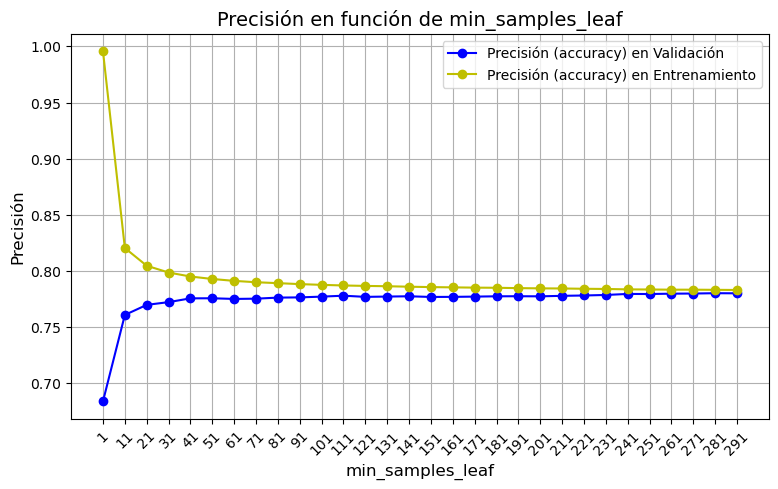

Mejor valor para mínimo número de muestras por nodo hoja: 271
Mejor precisión en validación: 0.43525313278720673


In [292]:
# Precisión (Accuracy)
prec_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_accuracy'])
prec_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_accuracy'])

# Creamos la gráfica de precisión vs. min_samples_leaf
plt.figure(figsize=(9,5))
plt.plot(valores_min_leaf, prec_val_arbol, marker='o', linestyle='-', color='b', label='Precisión (accuracy) en Validación')
plt.plot(valores_min_leaf, prec_train_arbol, marker='o', linestyle='-', color='y', label='Precisión (accuracy) en Entrenamiento')
plt.xlabel('min_samples_leaf', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión en función de min_samples_leaf', fontsize=14)
plt.grid(True)
plt.xticks(valores_min_leaf, rotation=45)
plt.legend()
plt.show()

# Mostrar el mejor hiperparámetro y su rendimiento (precisión)
print("Mejor valor para mínimo número de muestras por nodo hoja:", grid_arbol_clasif.best_params_['min_samples_leaf'])
print("Mejor precisión en validación:", grid_arbol_clasif.best_score_)

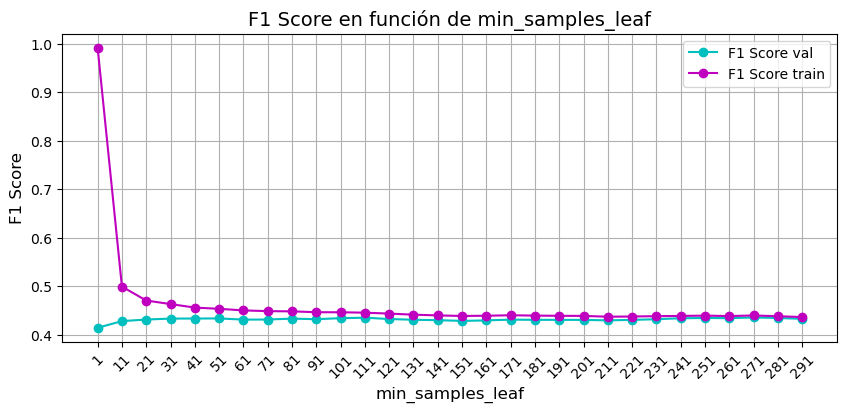

Mejor valor para mínimo número de muestras por nodo hoja: 271
Mejor F1 Score en validación: 0.43525313278720673


In [293]:
# F1-SCORE
f1_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_f1_macro'])
f1_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_f1_macro'])

# Creamos la gráfica de F1 Score vs. min_samples_leaf
plt.figure(figsize=(10, 4))
plt.plot(valores_min_leaf, f1_val_arbol, marker='o', linestyle='-', color='c', label='F1 Score val')
plt.plot(valores_min_leaf, f1_train_arbol, marker='o', linestyle='-', color='m', label='F1 Score train')
plt.xlabel('min_samples_leaf', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score en función de min_samples_leaf', fontsize=14)
plt.grid(True)
plt.xticks(valores_min_leaf, rotation=45)
plt.legend()
plt.show()

# Mostramos el mejor hiperparámetro y su rendimiento (F1 Score)
print("Mejor valor para mínimo número de muestras por nodo hoja:", grid_arbol_clasif.best_params_['min_samples_leaf'])
print("Mejor F1 Score en validación:", grid_arbol_clasif.best_score_)


Como podemos observar, el F1-Score (útil en clases desbalanceadas) refleja un muy mal rendimiento de este modelo. Esto ocurre en los árboles cuando los datos son desbalanceados, ya que el modelo podría sesgar hacia la clase mayoritaria. En este caso, el árbol de decisión podría aprender a predecir la clase mayoritaria la mayor parte del tiempo, logrando una alta precisión (de ahí altos valores de accuracy) pero sin detectar adecuadamente la clase minoritaria.
Que el F1-Score vaya decreciendo tiene sentido ya que cuanto mayor es el número mínimo de muestras por nodo hoja, menor es la profundida del árbol, por lo que el modelo se vuelve demasiado general en entrenamiento.

Es por esto, que la decisión final a la hora de elegir el hierparámetro es la de c=51, ya que el F1 score se mantiene en un valor de 0.4 pero la AUC y la precisión tienen buenos resultados.

- Visualice el árbol obtenido. Extraiga conclusiones sobre la importancia de determinadas
variables en la solución proporcionada por el árbol.

In [294]:
# Realizamos el arbol con nuestro valor de hiperparámetro escogido.
tree_clf = DecisionTreeClassifier(min_samples_leaf=51, random_state=0)
tree_clf.fit(X_train, y_train)     # Entrenamos el modelo
y_pred = tree_clf.predict(X_test)  # Predicciones

Como nuestro número de muestras es muy elevado, primero vamos a observar cuantas clases existen en nuestros nodo hoja.

In [296]:
def contar_nodos_hoja_por_clase(modelo_arbol):
    """
    Cuenta cuántos nodos hoja pertenecen a cada clase, basándose en la clase predominante
    en cada nodo hoja de un árbol de decisión.
    
    Parámetros:
    - modelo_arbol: DecisionTreeClassifier ya entrenado.
    
    Retorna:
    - Diccionario donde las claves son las clases y los valores son el número de nodos hoja
      que tienen esa clase como predominante.
    """
    
    # Obtenemos los nodos hoja
    nodos_hoja = np.where((modelo_arbol.tree_.children_left == -1) & 
                          (modelo_arbol.tree_.children_right == -1))[0]
    
    # Creamos un diccionario para contar los nodos hoja por clase
    nodos_por_clase = {clase: 0 for clase in modelo_arbol.classes_}
    
    for nodo in nodos_hoja:
        # Obtenemos el conteo de muestras por clase en este nodo
        valores = modelo_arbol.tree_.value[nodo][0]             # Array de conteos por clase
        clase_predominante = np.argmax(valores)                 # Clase dominante en el nodo hoja
        nodos_por_clase[clase_predominante] += 1
    
    return nodos_por_clase

# Usamos la función con el modelo entrenado
nodos_por_clase = contar_nodos_hoja_por_clase(tree_clf)

# Mostramos los resultados
for clase, cantidad in nodos_por_clase.items():
    print(f"Clase {clase}: {cantidad} nodos hoja")


Clase 0.0: 1061 nodos hoja
Clase 1.0: 0 nodos hoja
Clase 2.0: 187 nodos hoja


Como nuestro conjunto de entrenamiento tiene clases desbalanceadas y se utiliza un árbol muy profundo (con muchos nodos), algunos nodos hoja tienen muy pocos ejemplos de la clase minoritaria, por lo que no se representa.

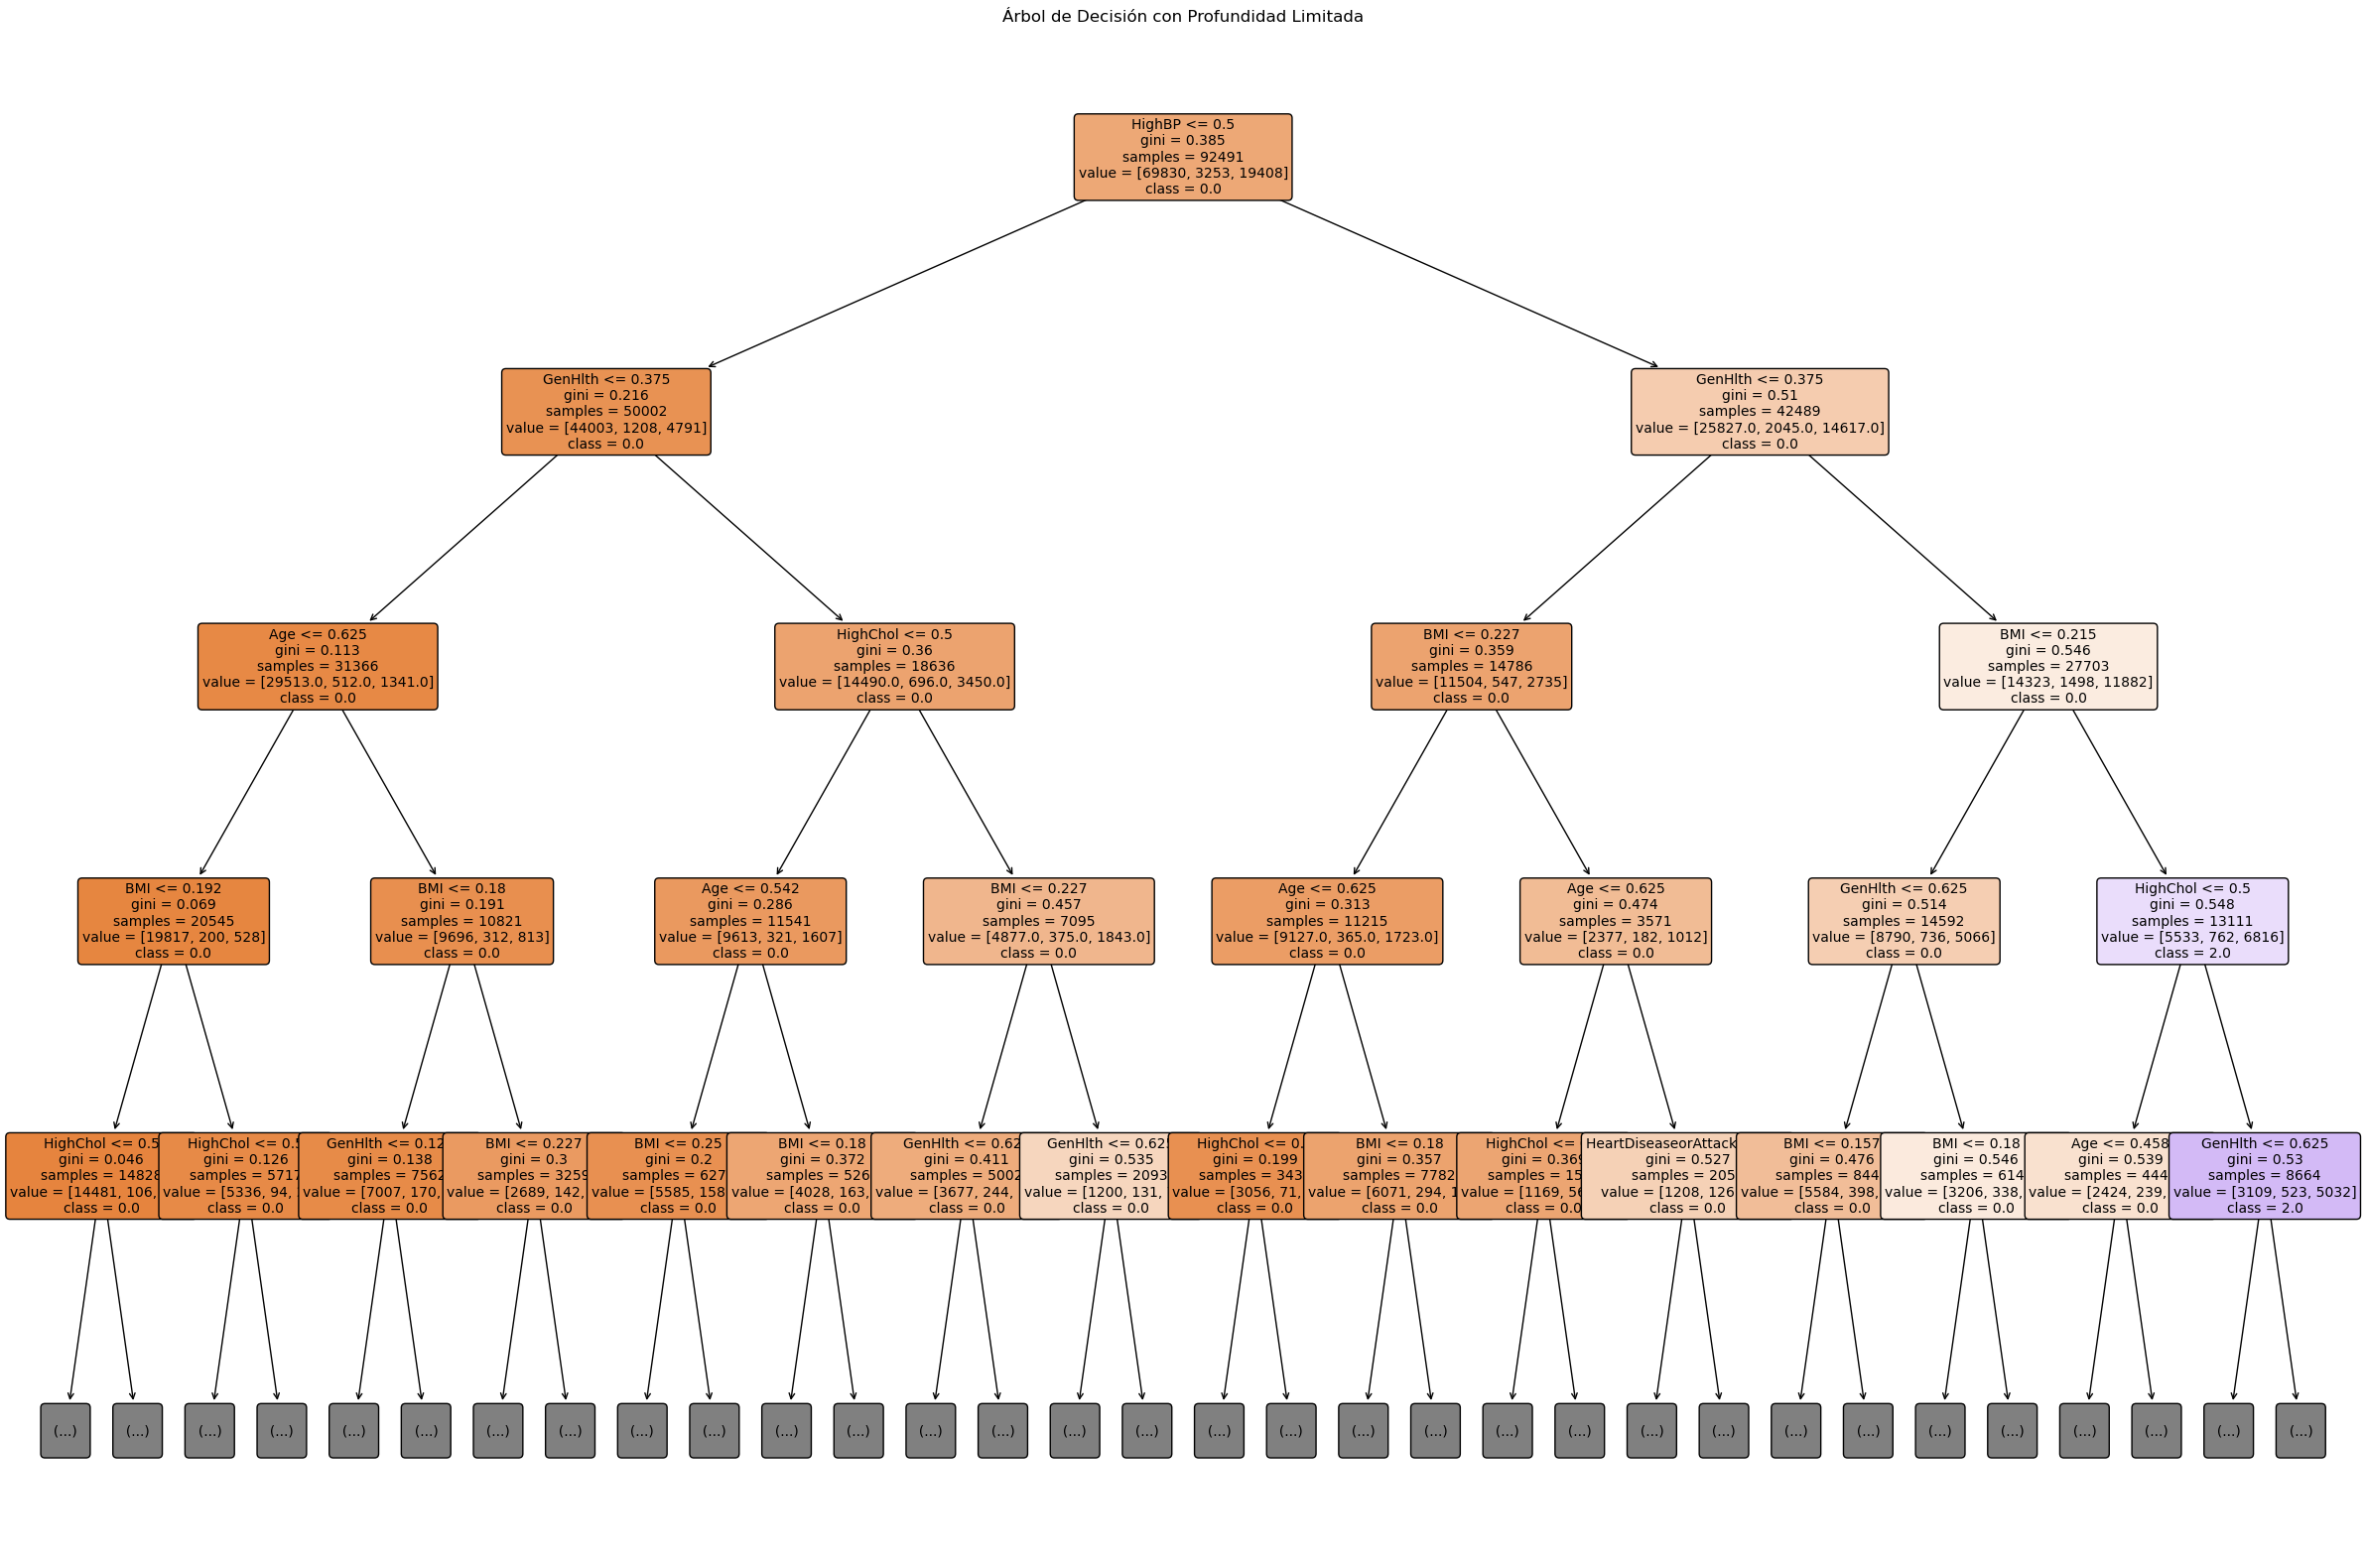

In [297]:
# Visualizamos el árbol
plt.figure(figsize=(30, 20))  # Reducimos el tamaño para simplificar
plot_tree(tree_clf, 
          max_depth=4,            # Limitar la profundidad a 4 niveles
          filled=True, 
          feature_names=X_train.columns, 
          class_names=[str(c) for c in tree_clf.classes_], 
          rounded=True, 
          fontsize=10)
plt.title("Árbol de Decisión con Profundidad Limitada")
plt.show()

Como se puede observar existen múltiples ramas con la opción de podar, ya que el resultado de la clasificación es el mismo.

Por tanto vemos que el hiperparámetro de "minímo numero de muestras por nodo hoja" no es el mejor para obtener el mejor rendimiento. 

Vamos a probar a usar el `max_depth. El parámetro max_depth controla la profundidad máxima del árbol de decisión, por lo que nos puede ayudar a visualizar el arbol. También evita la complejidad excesiva, ya que no necesitamos tantas rama puesto que la clasificación es la misma. Por tanto vamos a darle mucha importancia a este parámetro.

In [298]:
param_grid2 = {'max_depth': range(1,60,5)}  # Probamos valores de 1 a 60 para la profundidad máxima

# Creamos un scorer para calcular el ROC-AUC en problemas multiclase
roc_auc_scorer2 = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')  # Métrica personalizada

# Configurar GridSearchCV
grid_arbol_clasif2 = GridSearchCV(
    DecisionTreeClassifier(random_state=0),  # Modelo base a optimizar
    param_grid=param_grid2,  # Hiperparámetros a explorar
    scoring=roc_auc_scorer2,  # Métrica de evaluación
    cv=3,  # Validación cruzada con 3 particiones
    return_train_score=True  # Guardar resultados del conjunto de entrenamiento
)

# Entrenar el modelo con las combinaciones de hiperparámetros
grid_arbol_clasif2.fit(X_train, y_train)

# Imprimir los resultados
print("Mejor valor del hiper-parámetro max depth:", grid_arbol_clasif2.best_params_)  # Hiperparámetro óptimo
print("Mejor ROC-AUC en validación: {:.3f}".format(grid_arbol_clasif2.best_score_))  # Mejor desempeño


Mejor valor del hiper-parámetro max depth: {'max_depth': 6}
Mejor ROC-AUC en validación: 0.756


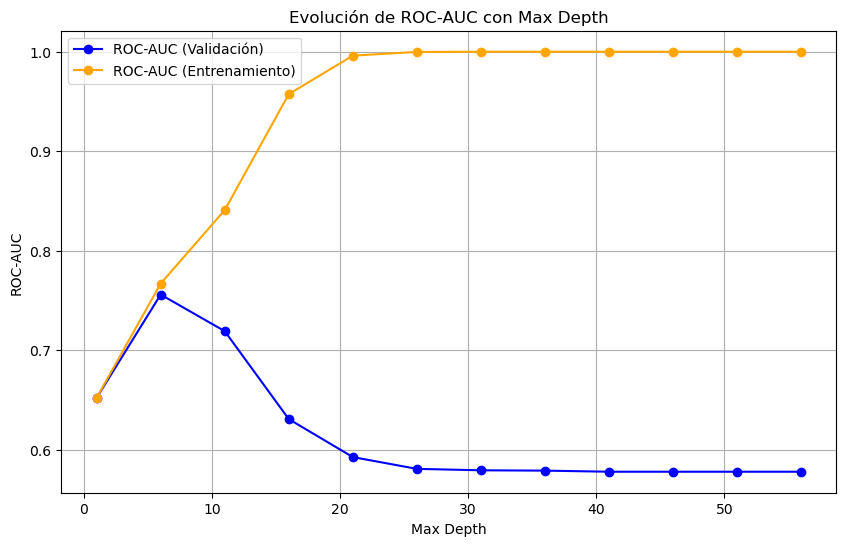

Mejor valor para Max_Depth: 6
Mejor ROC-AUC validación: 0.7558983925329379


In [300]:
# Extraemos los resultados de la validación cruzada para 'max_depth'
mean_test_scores = grid_arbol_clasif2.cv_results_['mean_test_score']
mean_train_scores = grid_arbol_clasif2.cv_results_['mean_train_score']

# Graficamos ROC-AUC en validación y entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(param_grid2['max_depth'], mean_test_scores, marker='o', label='ROC-AUC (Validación)', color='blue')
plt.plot(param_grid2['max_depth'], mean_train_scores, marker='o', label='ROC-AUC (Entrenamiento)', color='orange')
plt.xlabel('Max Depth')
plt.ylabel('ROC-AUC')
plt.title('Evolución de ROC-AUC con Max Depth')
plt.legend()
plt.grid(True)
plt.show()

# Mostramos el mejor hiperparámetro y su rendimiento (F1 Score)
print("Mejor valor para Max_Depth:", grid_arbol_clasif2.best_params_['max_depth'])
print("Mejor ROC-AUC validación:", grid_arbol_clasif2.best_score_)

Esta claro que el mejor valor es de max_depth=6, ya que a partir de ese valor el arbol sobreajusta y los resultados empeoran en el conjunto de validación. Además, hemos obtenido un resultado en validación por encima de cualquier otro conseguido por el otro hipeparámetro.
Vamos por tanto a observar el arbol obtenido:

In [301]:
# Realizamos el arbol con nuestro valor de hiperparámetro escogido.
tree_clf2 = DecisionTreeClassifier(max_depth=6, random_state=0)
tree_clf2.fit(X_train, y_train)                 # Entrenamos el modelo
y_pred = tree_clf2.predict(X_test)              # Predicciones

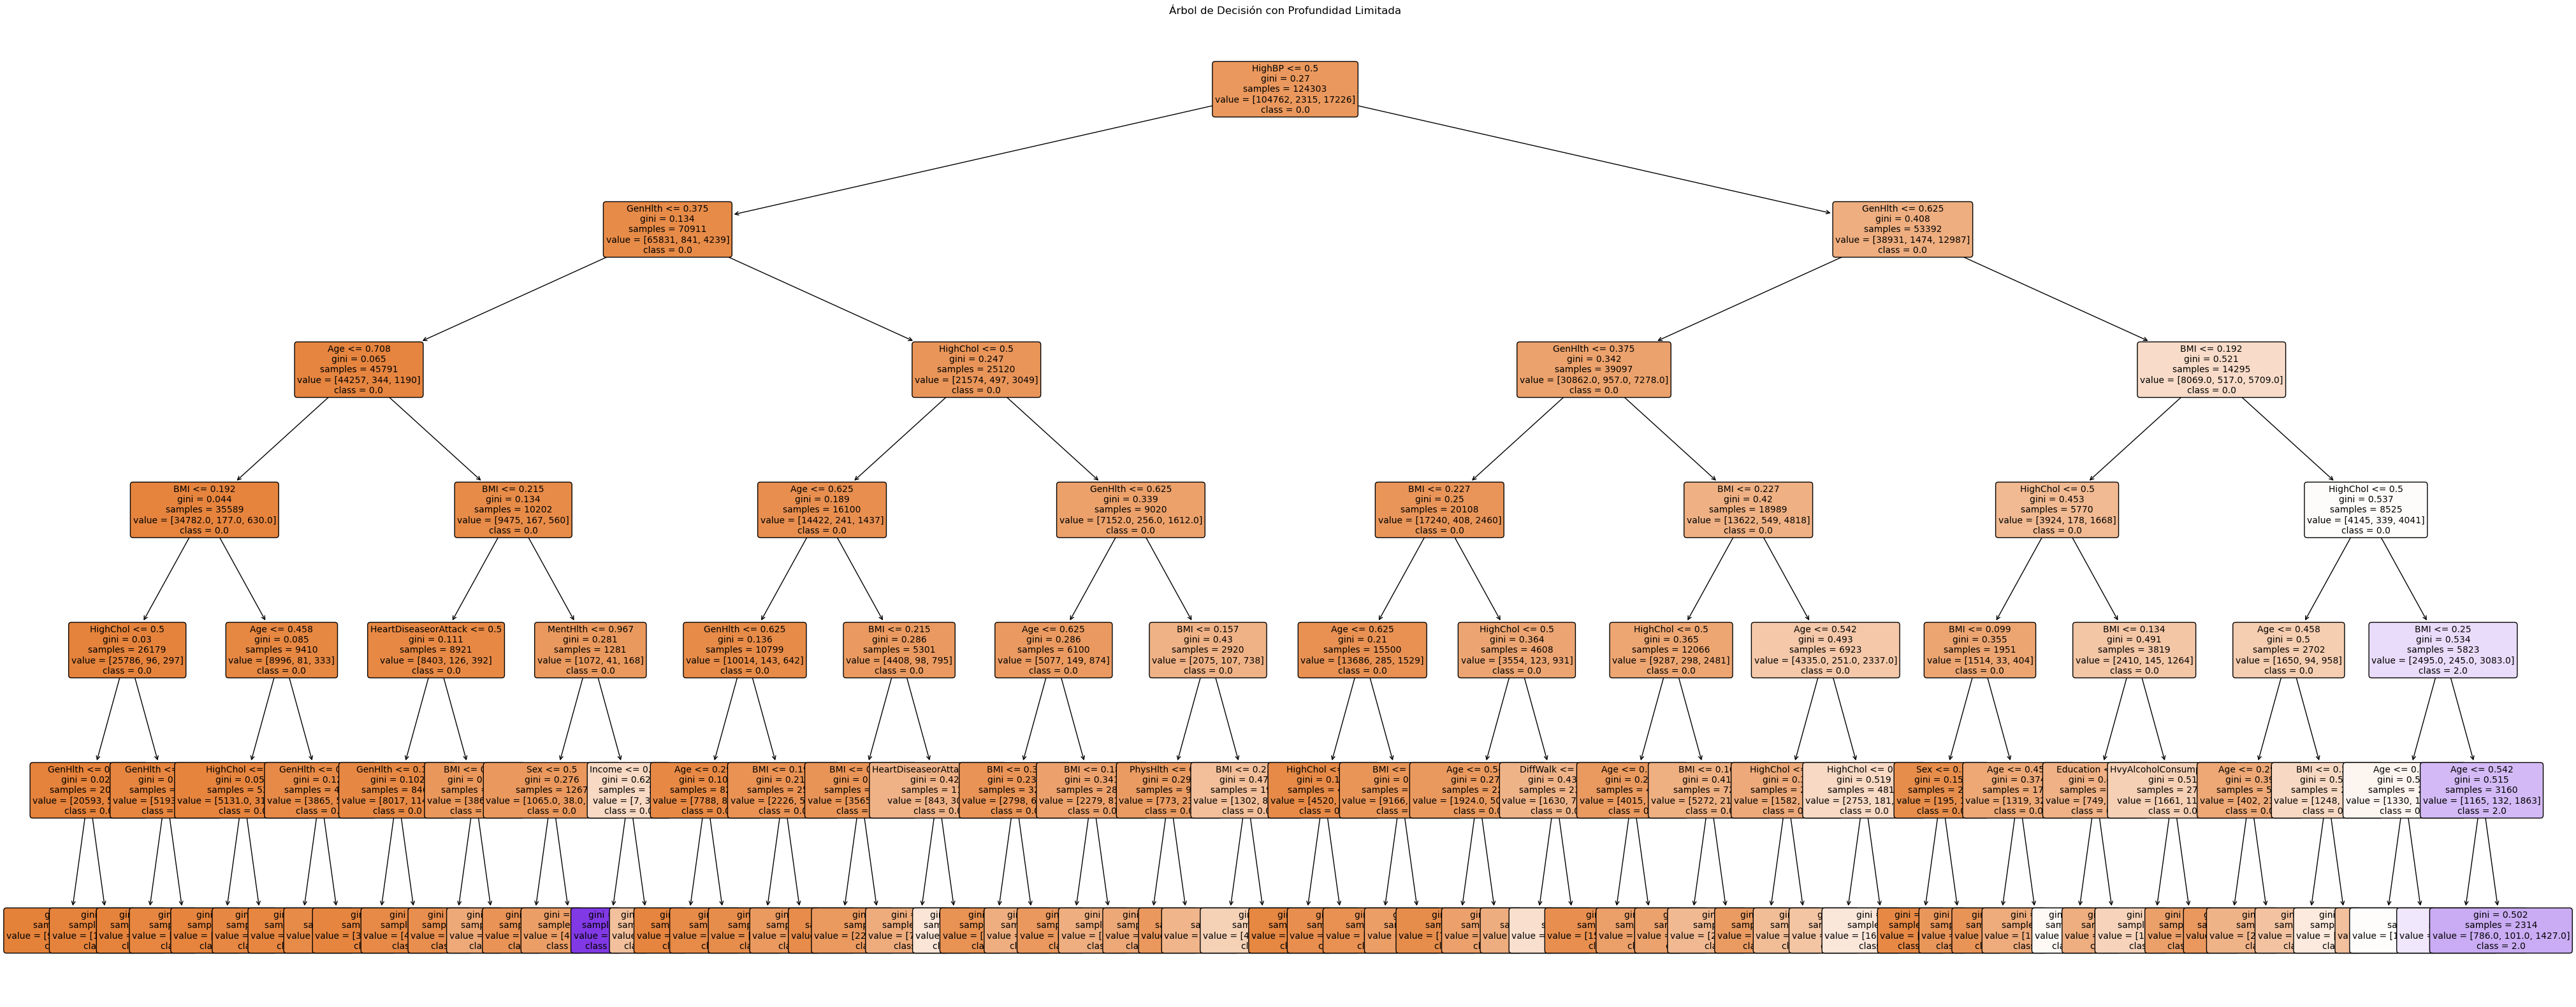

In [187]:
# Visualizamos el árbol
plt.figure(figsize=(50, 20))  # Reducimos el tamaño para simplificar
plot_tree(tree_clf2, 
          filled=True, 
          feature_names=X_train.columns, 
          class_names=[str(c) for c in tree_clf.classes_], 
          rounded=True, 
          fontsize=10)
plt.title("Árbol de Decisión con Profundidad Limitada")
plt.show()

In [302]:
# Usamos la función con el modelo entrenado
nodos_por_clase = contar_nodos_hoja_por_clase(tree_clf2)

# Mostramos los resultados
for clase, cantidad in nodos_por_clase.items():
    print(f"Clase {clase}: {cantidad} nodos hoja")

Clase 0.0: 56 nodos hoja
Clase 1.0: 0 nodos hoja
Clase 2.0: 8 nodos hoja


Podemos observar que seguimos sin poder clasificar a los pacientes prediabéticos.

- Con el valor elegido, utilice 4 figuras de mérito para estimar las prestaciones sobre un
conjunto de test independiente del utilizado en el diseño. Comente los resultados
obtenidos.

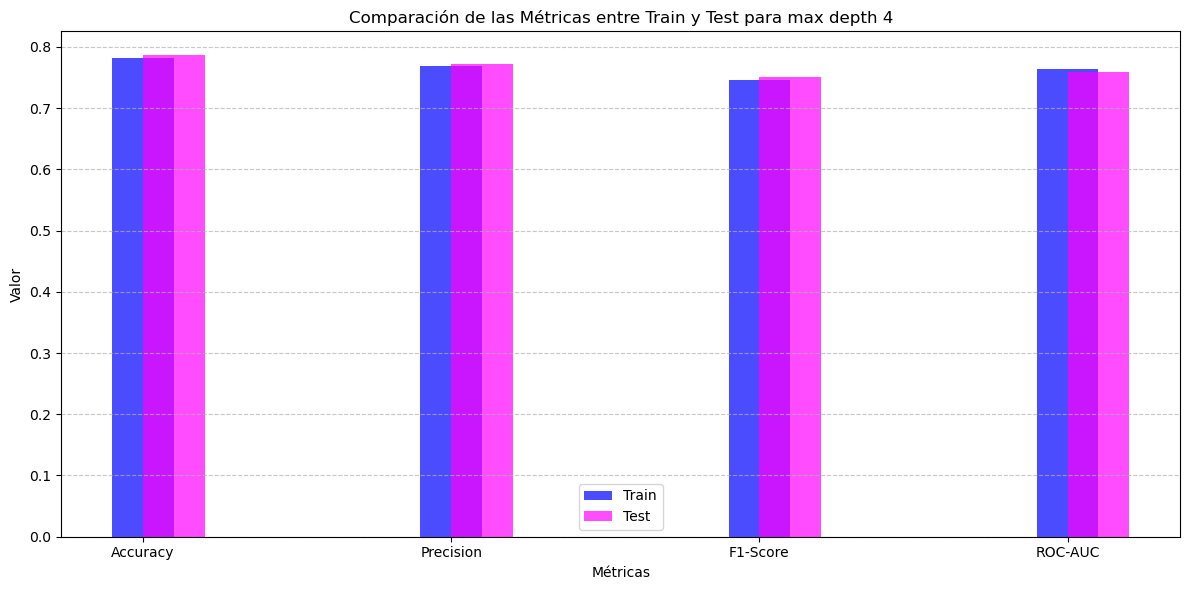

In [310]:
# Predecimos en los conjuntos de train y test
y_train_pred = tree_clf2.predict(X_train)
y_train_pred_proba= tree_clf2.predict_proba(X_train)

y_test_pred = tree_clf2.predict(X_test)
y_test_pred_proba= tree_clf2.predict_proba(X_test)


# Calculamos las métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted',zero_division=1)        # Como hay clases que no tienen predicciones hay que ajustar el zero division.
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_roc_auc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')

# Calculamos las métricas para el conjunto de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=1)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')

# Crear listas con los valores de las métricas
metrics = ['Accuracy', 'Precision', 'F1-Score', 'ROC-AUC']
train_scores = [train_accuracy, train_precision, train_f1, train_roc_auc]
test_scores = [test_accuracy, test_precision, test_f1, test_roc_auc]

# Crear las gráficas
plt.figure(figsize=(12, 6))

# Comparación de las métricas entre train y test
x = range(len(metrics))
plt.bar(x, train_scores, width=0.2, label='Train', align='center', alpha=0.7, color='blue')
plt.bar(x, test_scores, width=0.2, label='Test', align='edge', alpha=0.7, color='magenta')

# Añadir detalles de la gráfica
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparación de las Métricas entre Train y Test para max depth 4')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

ROC-AUC: 0.759
Accuracy: 0.786
F1-Score: 0.751


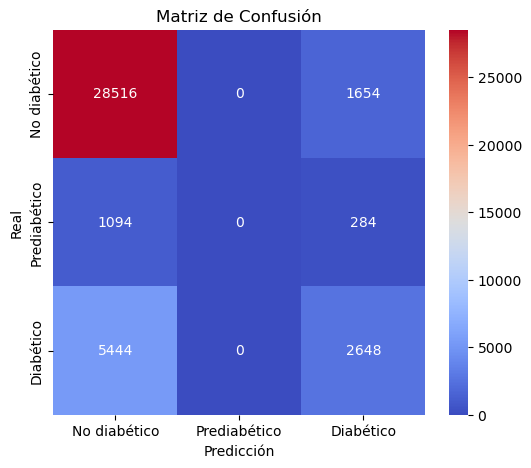

In [311]:
# ROC_AUC
roc_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
print(f"ROC-AUC: {roc_auc:.3f}")

# Accuracy
accuracy = test_accuracy
print(f"Accuracy: {accuracy:.3f}")

# F1 Score
f1 = test_f1
print(f"F1-Score: {f1:.3f}")

# Matriz de Confusión
conf_matrix_arbol= confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_arbol, annot=True, fmt='d', cmap='coolwarm', xticklabels=datanames, yticklabels=datanames)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Confusion Matrix: Podemos ver que la sensibilidad en pacientes sanos es muy buena, pero la precisión en los diabéticos es muy mala, y no clasifica a los prediabéticos.  

ROC-AUC (0.759) Este valor refleja un desempeño sólido del modelo en términos de su capacidad para distinguir entre las clases. Al estar cerca de 1, indica que el modelo tiene una buena capacidad discriminativa, aunque no es perfecto.

Accuracy (0.786): La exactitud del modelo es del 84.8%, lo que indica que el modelo está clasificando correctamente un 85% de las muestras en el conjunto de prueba. Aunque es un buen resultado, también sugiere que hay margen de mejora, ya que aproximadamente el 15% de las predicciones son incorrectas.

F1-Score (0.751): El F1-Score es una métrica que combina la precisión y la sensibilidad, tomando en cuenta tanto los falsos positivos como los falsos negativos. Un valor de 0.797 refleja un buen balance entre estas dos métricas, lo que sugiere que el modelo está equilibrado, aunque aún puede mejorarse.

## **c) Perceptrón Multicapa o MLP (Multi-Layer Perceptron)**

- En términos de subajuste y sobreajuste, justifique razonadamente cuál de ellos es más
probable que ocurra si para resolver la tarea se considera una única capa oculta con una
neurona. Realice el diseño correspondiente y obtenga las prestaciones del modelo
considerando distintas figuras de mérito.

Obtendríamos más facilmente subajuste debido a que nuestro modelo solo puede aprender funciones lineales o hacer separaciones muy simples de los datos. Por lo que ofrecería bajo rendimiento en problemas un poco complejos.

In [320]:
# Modelo MLP con una sola capa oculta y una neurona
mlp_single_neuron = MLPClassifier(hidden_layer_sizes=(1,), max_iter=1000, random_state=42)
mlp_single_neuron.fit(X_train, y_train)

# Predicción y evaluación
y_pred_train = mlp_single_neuron.predict(X_train)
y_pred_test = mlp_single_neuron.predict(X_test)


# Obtenemos el classification report como un diccionario
train_report = classification_report(y_train, y_pred_train, zero_division=0, output_dict=True)
test_report = classification_report(y_test, y_pred_test, zero_division=0, output_dict=True)

# Convertimos los reportes en DataFrames
train_df = pd.DataFrame(train_report).transpose()
test_df = pd.DataFrame(test_report).transpose()

# Obtenemos ROC-AUC para entrenamiento y prueba
train_roc_auc = roc_auc_score(y_train, mlp_single_neuron.predict_proba(X_train), multi_class='ovr')
test_roc_auc = roc_auc_score(y_test, mlp_single_neuron.predict_proba(X_test), multi_class='ovr')

# Agregamos ROC-AUC al DataFrame
train_df['ROC-AUC'] = train_roc_auc
test_df['ROC-AUC'] = test_roc_auc

''' # Función para aplicar estilo a los DataFrames
def style_dataframe(df, title):
    return (
        df.style
        .format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'ROC-AUC': '{:.3f}'})
        .set_caption(title)  # Título del DataFrame
        .highlight_max(axis=0, props='font-weight: bold; color: black;')  # Resalta valores máximos
        .set_properties(**{'text-align': 'center'})  # Centra los valores
    )

# Mostramos los DataFrames con estilo
display(style_dataframe(train_df, " Métricas de Clasificación - Conjunto de Entrenamiento"))
display(style_dataframe(test_df, "Métricas de Clasificación - Conjunto de Test"))
'''
# Mostrar los reportes
print("Reporte de clasificación para entrenamiento:")
print(train_df)

print("\nReporte de clasificación para prueba:")
print(test_df)


Reporte de clasificación para entrenamiento:
              precision    recall  f1-score       support   ROC-AUC
0.0            0.754992  1.000000  0.860394  69830.000000  0.500005
1.0            0.000000  0.000000  0.000000   3253.000000  0.500005
2.0            0.000000  0.000000  0.000000  19408.000000  0.500005
accuracy       0.754992  0.754992  0.754992      0.754992  0.500005
macro avg      0.251664  0.333333  0.286798  92491.000000  0.500005
weighted avg   0.570013  0.754992  0.649591  92491.000000  0.500005

Reporte de clasificación para prueba:
              precision    recall  f1-score     support  ROC-AUC
0.0            0.761100  1.000000  0.864346  30170.0000  0.49978
1.0            0.000000  0.000000  0.000000   1378.0000  0.49978
2.0            0.000000  0.000000  0.000000   8092.0000  0.49978
accuracy       0.761100  0.761100  0.761100      0.7611  0.49978
macro avg      0.253700  0.333333  0.288115  39640.0000  0.49978
weighted avg   0.579273  0.761100  0.657854  39640

- Explique si considera razonable abordar el diseño de un MLP con una única capa oculta
de neuronas. Explique, aplicado a su conjunto de observaciones, a qué hace referencia
la afirmación “El MLP es un aproximador universal”.

Una única capa oculta puede ser adecuada para problemas en los que las clases son linealmente separables o cuando las relaciones entre las características son simples. Sin embargo, en problemas más complejos (como en este caso, con múltiples clases y relaciones no lineales), una sola capa oculta resulta insuficiente, lo que hace que este diseño no sea adecuado.
El “El MLP es un aproximador universal" se refiere a que con una sola capa oculta y suficientes neuronas es capaz de aproximar cualquier función continua en el espacio de entrada. Sin embargo, esto requeriría un número muy alto de neuronas, lo que podría generar problemas prácticos durante el entrenamiento, como tiempos de procesamiento elevados o riesgo de sobreajuste.

- Discuta la necesidad o no de normalizar las características antes de realizar el
entrenamiento del modelo.

Es crucial realizar la normalización de las características en un MLP, ya que las redes neuronales son sensibles a las diferencias en las escalas de las entradas. El entrenamiento se basa en la optimización de los pesos mediante el uso de gradientes, y sin normalización, las características con valores más grandes pueden dominar el proceso de aprendizaje, lo que dificulta la convergencia del modelo.

Cuando las características de entrada no están en la misma escala, las de valores más altos tendrán un mayor impacto en los gradientes, lo que puede hacer que las variables con valores bajos sean prácticamente ignoradas durante el entrenamiento.
Los pesos de las características con valores más grandes tienden a ajustarse rápidamente, mientras que los pesos de las características con valores más pequeños se actualizan muy poco, lo que resulta en un proceso de aprendizaje desequilibrado y menos eficiente.
Al normalizar las características, todas las variables se encuentran en el mismo rango y reciben la misma importancia durante el proceso de entrenamiento, lo que mejora la eficiencia y la precisión del modelo.


- Entrene un MLP considerando una única capa oculta y distinto número de neuronas
ocultas haciendo uso sólo de un esquema de aprendizaje “batch” y considerando
suficientes épocas (o iteraciones). Monitorice y represente la evolución del valor de
la figura de mérito que considere más adecuada para abordar su tarea y detenga el 4
proceso iterativo de aprendizaje en función del valor de esa figura de mérito. ¿Qué
arquitectura ha elegido? Justifique su respuesta.

La mejor figura de mérito es selecciona el ROC-AUC  debido a su capacidad para evaluar el desempeño de un modelo en tareas de clasificación multiclase. Esta métrica es relevante ya que evalúa el balance entre la sensibilidad y la especificidad, lo cual es esencial en problemas con desbalance de clases, ya que puede influir considerablemente en métricas como la precisión.

Tiempo de ejecución del MLP de 5 neuronas : 0.8991 minutos
Tiempo de ejecución del MLP de 10 neuronas : 0.6778 minutos
Tiempo de ejecución del MLP de 20 neuronas : 1.1369 minutos
Tiempo de ejecución del MLP de 50 neuronas : 1.4420 minutos


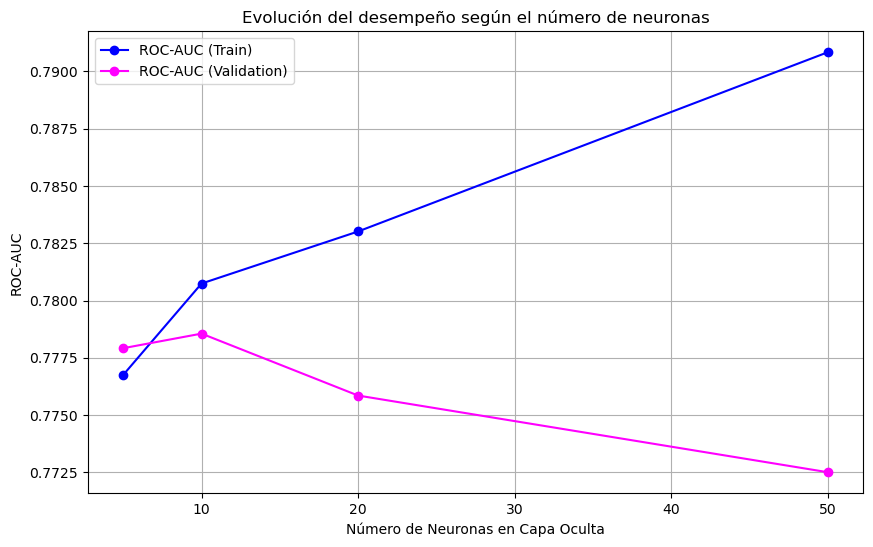

Mejor arquitectura: 10 neuronas ocultas
Tiene un valor de ROC_AUC de:0.7785567253617879


In [318]:
# Configuramos parámetros
hidden_neurons = [5, 10, 20, 50]  # Números de neuronas a probar
epochs = 500
roc_auc_train = []
roc_auc_val = []

# Entrenamiento con diferentes arquitecturas
for neurons in hidden_neurons:
    mlp = MLPClassifier(hidden_layer_sizes=(neurons,), max_iter=epochs, random_state=42, batch_size=32)
    # Medimos el tiempo de ejecución
    start_time = time.time()  # Tiempo de inicio
    mlp.fit(X_train, y_train)
    # Tiempo de finalización
    end_time = time.time()
    # Calculamos y mostramos el tiempo total
    execution_time = (end_time - start_time)/60
    print(f"Tiempo de ejecución del MLP de {neurons} neuronas : {execution_time:.4f} minutos")
    
    # Métricas
    train_pred = mlp.predict_proba(X_train)
    val_pred = mlp.predict_proba(X_test)
    
    roc_auc_train.append(roc_auc_score(y_train, train_pred, multi_class='ovr'))
    roc_auc_val.append(roc_auc_score(y_test, val_pred, multi_class='ovr'))

# Visualización del desempeño
plt.figure(figsize=(10, 6))
plt.plot(hidden_neurons, roc_auc_train, marker='o', label='ROC-AUC (Train)', color='blue')
plt.plot(hidden_neurons, roc_auc_val, marker='o', label='ROC-AUC (Validation)', color='magenta')
plt.xlabel('Número de Neuronas en Capa Oculta')
plt.ylabel('ROC-AUC')
plt.title('Evolución del desempeño según el número de neuronas')
plt.legend()
plt.grid(True)
plt.show()

# Seleccionar la mejor arquitectura
best_neurons = hidden_neurons[roc_auc_val.index(max(roc_auc_val))]
print(f"Mejor arquitectura: {best_neurons} neuronas ocultas")
print(f"Tiene un valor de ROC_AUC de:{max(roc_auc_val)}")

Durante el entrenamiento del MLP, se realiza un seguimiento del progreso del ROC-AUC en cada época utilizando un conjunto de validación o validación cruzada. Esto se hace para asegurarse de que cualquier mejora observada en esta métrica no se deba a un sobreajuste de los datos de entrenamiento. El proceso de entrenamiento se detiene cuando el ROC-AUC en el conjunto de validación deja de mejorar de manera significativa durante un número determinado de épocas consecutivas, lo que indica que el modelo ha alcanzado la convergencia y previene el sobreentrenamiento innecesario.

Se probaron diversas configuraciones para el número de neuronas en la capa oculta, y se observó que la arquitectura óptima es aquella con 10 neuronas. Esta configuración alcanza un máximo en la curva del ROC-AUC para el conjunto de validación, lo que señala el mejor rendimiento del modelo en datos no observados. Además, el número de neuronas no es excesivo, lo que contribuye a un modelo más simple sin perder precisión.

- Utilice la arquitectura elegida para evaluar las prestaciones del modelo sobre el conjunto
de test, obteniendo los valores asociados a las 4 figuras de mérito anteriores. Comente
los resultados obtenidos.

In [321]:
# Entrenmos modelo con la mejor arquitectura
mlp_best = MLPClassifier(hidden_layer_sizes=(best_neurons,), max_iter=epochs, random_state=42, batch_size=32)
mlp_best.fit(X_train, y_train)

# Predicciones
test_pred = mlp_best.predict(X_test)
test_pred_proba = mlp_best.predict_proba(X_test)

# Evaluación
roc_auc_test = roc_auc_score(y_test, test_pred_proba, multi_class='ovr')
accuracy_test = accuracy_score(y_test, test_pred)
f1_test = f1_score(y_test, test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, test_pred)

Accuracy de la clase 0: 0.98
Accuracy de la clase 1: 0.00
Accuracy de la clase 2: 0.19


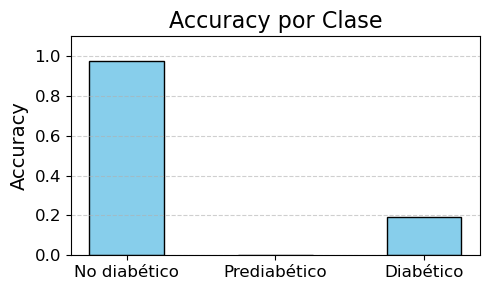

In [231]:
# Calculamos el accuracy por clase
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)   # La diagonal tiene los TP por clase. La suma obtiene todas las observaciones

# Visualizamos el accuracy por clase
for i, acc in enumerate(accuracy_per_class):
    print(f'Accuracy de la clase {i}: {acc:.2f}')

plt.figure(figsize=(5, 3))
bars = plt.bar(datanames, accuracy_per_class, color='skyblue', edgecolor='black',width=0.5)

plt.title('Accuracy por Clase', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # El límite superior para dar espacio a los valores encima de las barras
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Se puede observar como el modelo no clasifica bien las clases diabéticos y prediabéticos.

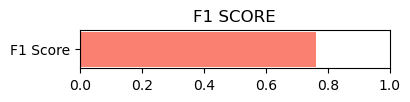

F1-Score (Weighted) del MLP con 10 neuronas: 0.7626421603579544


In [322]:
# Calcular el F1-Score para el problema multiclase
f1 = f1_score(y_test, test_pred, average='weighted')  # 'weighted' calcula el promedio ponderado por la frecuencia de cada clase

# Mostrar el resultado
plt.figure(figsize=(4, 0.5))
plt.barh(['F1 Score'], [f1], color='salmon')
plt.xlim(0, 1)
plt.title('F1 SCORE')
plt.show()

print(f'F1-Score (Weighted) del MLP con 10 neuronas: {f1}')

El modelo tiene un buen equilibrio entre precisión y recall, pero dado osbretodo por la clase Diabéticos.

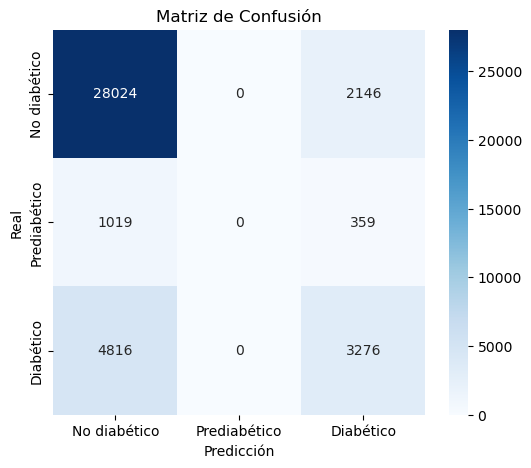

In [323]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=datanames, yticklabels=datanames)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

El modelo tiene una tasa razonable de predicciones correctas entre las que fueron clasificadas como positivas. Sin embargo, no es un valor muy alto, lo que sugiere que podría haber espacio para mejorar la capacidad del modelo de predecir correctamente las clases positivas.

AUC en test de clase No diabético= 0.824004348466749
AUC en test de clase Prediabético= 0.6848389254774525
AUC en test de clase Diabético= 0.8268269021411621


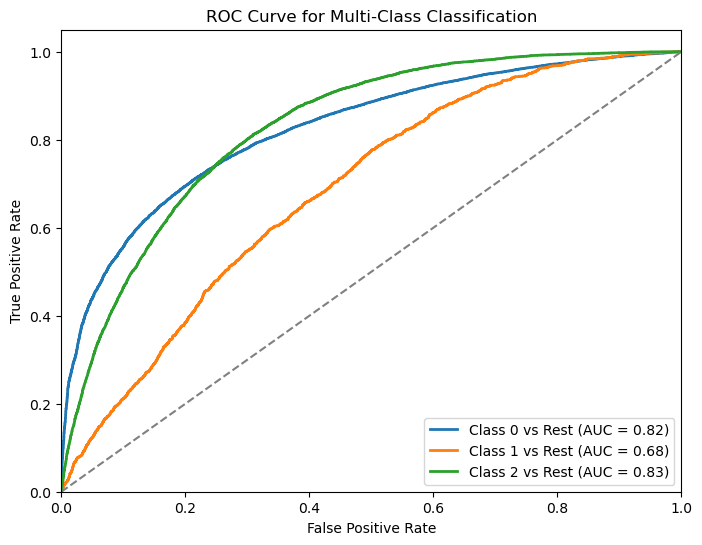

ROC-AUC: 0.779


In [324]:
# Predicciones de probabilidad
y_test_pred_proba_mlp = mlp_best.predict_proba(X_test)

datanames=['No diabético', 'Prediabético', 'Diabético']      # Nombres de las clases
                                                                        # Binarizar las etiquetas de las clases
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Calcular ROC-AUC para cada clase
roc_auc_test = roc_auc_score(y_test_bin, test_pred_proba, multi_class='ovr')

plt.figure(figsize=(8, 6))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba_mlp[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')
    print(f"AUC en test de clase {datanames[i]}= {roc_auc}")
    
# Añadir la línea diagonal (sin discriminación)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Añadir etiquetas y título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')

plt.show()

# Imprimir métricas
print(f"ROC-AUC: {roc_auc_test:.3f}")

Este valor indica un desempeño bastante bueno del modelo, pues está cerca de 1, lo que significa que el modelo es capaz de diferenciar bastante bien entre las clases. 
Detecta muy bien sobretodo la clase 0 (Sanos), y tiene un buen rendimiento en la clase 2 (diabéticos).Sin embargo, en esta clase auqnue la AUC es alta, la curva ROC se acerca más al vértice derecho, por lo que indica un peor desmepeño de lo que nos puede hacer ver el AUC. 
La clase 1 se mantiene en un nivel de AUC aceptable debido a los pocos valores que tiene, pero tampoco refleja la realidad.

## **d) Selección de características**

Como se ha indicado durante las sesiones de la asignatura, no existe un procedimiento universal de selección de características** aplicable a cualquier conjunto de observaciones.
Más bien, es necesario considerar distintas alternativas y valorar los pros y contras de cada
estrategia, de manera que se pueda aportar una solución final razonable.
- Justifique razonadamente la elección de un método de cada uno de los tres tipos (filter,wrapper y embedded) para determinar un subconjunto informativo de las características originales. Utilizando sus propias palabras, explique el uso de cada uno de ellos.
- Aplique cada uno de los métodos elegidos (al menos tres, uno de cada tipo)*** para seleccionar un subconjunto de entre las características originalmente disponibles.
Resuelva la tarea de clasificación (cada grupo, la tarea asociada) utilizando cada uno de los subconjuntos de características elegidos (considerando las mismas observaciones que en los apartados anteriores). Para ello, elija el mismo esquema de
aprendizaje para los métodos filter y wrapper. Discuta los resultados y extraiga
conclusiones.

***Nota-3: Si puede utilizar alguno de los resultados obtenidos en los apartados asociados
a la entrega del Tema 4, no debe repetir las ejecuciones (en caso de hacerlo, se valorará
negativamente).

La seleccción de características es un proceso subjetivo a cada proyecto. En nuestro caso, partimos de una base de datos con muchas características discretas como la salud general (GenHealth), y solo una variable continua (BMI). Además, nuestro target es una variable categórica multiclase (3 clases).

Dentro de la selección de características tenemos diferentes tipos:

- Métodos de filtrado (filter): Estos métodos evalúan la importancia de las características de forma independiente.
  - Son rápidos y eficientes, ya que no necesitan entrenar modelos.
  - Funcionan bien con datasets grandes.
  - No dependen de un modelo específico, por lo que son generales

Dentro de este tipo podemos encontrar métodos como la selección por Correlación, las pruebas estadísticas y modelos de información mutua.

Aqui, hemos elegido la información mutua, que mide la cantidad de información compartida entre una característica y la variable objetivo. La hemos escogido porque es una medida más general que funciona tanto con variables continuas como discretas, lo que la hace muy útil cuando se tiene una mezcla de tipos de datos.

In [489]:
# Filter: Selección basada en Informacion Mutua
def filter_selection(X_train, X_test, y_train):
    selector = SelectKBest(score_func=mutual_info_classif, k=8)  # Selecciona las 6 mejores características
    X_train_filter = selector.fit_transform(X_train, y_train)
    X_test_filter = selector.transform(X_test)
    selected_features = X_train.columns[selector.get_support()]
    selector_scorer = selector.scores_
    
    return X_train_filter, X_test_filter, selected_features, selector_scorer

In [490]:
X_train_filter, X_test_filter, features_filter,scorer_filter = filter_selection(X_train, X_test, y_train)

# Mostramos las características seleccionadas
print("\nCaracterísticas seleccionadas:")
print(features_filter)

# Mostramos los valores de la información mutua para cada característica
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': scorer})
print("\nInformación mutua para cada característica:")
print(mi_scores_df.sort_values(by='Mutual Information', ascending=False))


Características seleccionadas:
Index(['HighBP', 'HighChol', 'BMI', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age',
       'Income'],
      dtype='object')

Información mutua para cada característica:
                 Feature  Mutual Information
13               GenHlth            0.066370
0                 HighBP            0.056418
3                    BMI            0.042103
1               HighChol            0.037013
18                   Age            0.033398
16              DiffWalk            0.029602
15              PhysHlth            0.024172
20                Income            0.024070
7           PhysActivity            0.021726
2              CholCheck            0.017667
6   HeartDiseaseorAttack            0.015966
19             Education            0.015334
9                Veggies            0.014588
11         AnyHealthcare            0.013557
8                 Fruits            0.013238
4                 Smoker            0.010657
17                   Sex            0.00

- Métodos wrapper: Seleccionan características utilizando un modelo de Machine Learning como parte del proceso. Evalúan diferentes subconjuntos de características entrenando y validando el modelo repetidamente.
    - Consideran interacciones entre características
    - Suelen producir mejores resultados que los métodos de filtro.

Lo malo es que son computacionalmente costosos, ya que requieren entrenar el modelo muchas veces, y dependientes del modelo usado (si cambia el modelo, pueden cambiar las características seleccionadas).


In [491]:
# Wrapper: Sequential Forward Selection (SFS) con LGB
def wrapper_selection(X_train, X_test, y_train):
    knn = KNeighborsClassifier(n_neighbors=20)                 # Ya vimos que el modelo no cambia tanto de k=20 a k=40
    sfs = SequentialFeatureSelector(knn, n_features_to_select=8, direction='forward',n_jobs=-1, cv=3)
    X_train_wrapper = sfs.fit_transform(X_train, y_train)
    X_test_wrapper = sfs.transform(X_test)
    selected_features = X_train.columns[sfs.get_support()]
    
    return X_train_wrapper, X_test_wrapper, selected_features

In [541]:
# Medimos el tiempo de ejecución
start_time = time.time()                                 # Tiempo de inicio

X_train_wrapper, X_test_wrapper, features_wrapper = wrapper_selection(X_train, X_test, y_train)
    
end_time = time.time()                                   # Tiempo de finalización
execution_time = (end_time - start_time)/60              # Calculamos y mostramos el tiempo total

print(f"Tiempo de ejecución del Filtro Wrapper SFS con KNN: {execution_time:.4f} minutos")

Tiempo de ejecución del Filtro Wrapper SFS con KNN: 12.5192 minutos


In [493]:
# Mostramos las características seleccionadas
print("\nCaracterísticas seleccionadas:")
print(features_wrapper)


Características seleccionadas:
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack',
       'HvyAlcoholConsump', 'GenHlth', 'Age'],
      dtype='object')


Hay que tener en cuenta que el KNN  se utiliza dos veces al hacer un wrapper filter:
Primera vez (en SFS): Se usa solo para evaluar qué características son útiles, pero no entrena un modelo final.
Segunda vez (para entrenar): Después de seleccionar características, se entrena el modelo final con KNN(n_neighbors=30).

- Métodos embedded
  
Los métodos embebidos permiten que el modelo aprenda a qué características asignar importancia mientras se entrena, a diferencia de los métodos de filtro (que realizan la selección antes del entrenamiento) y los métodos wrapped (que evalúan características basadas en el rendimiento del modelo).

Se ha elegido un modelo Ligth Gradient Boosting Machine (LGBM) porque es eficaz con datasets muy grandes  y maneja cualquier tipo de dato.

In [550]:
# Embedded: Árbol de decisión
def embedded_selection(X_train, X_test, y_train):
    model= lgb.LGBMClassifier(random_state=42, n_estimators=500, importance_type='gain')
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    top_k_features = np.argsort(importances)[-8:]         # Índices de las k=8 características más importantes
    selected_features = X_train.columns[top_k_features]  # Selecciona características relevantes (>1% importancia)
    
    X_train_embedded = X_train[selected_features]
    X_test_embedded = X_test[selected_features]
    
    return X_train_embedded, X_test_embedded, selected_features,model

In [543]:
X_train_embedded, X_test_embedded, features_embedded,model_embedded = embedded_selection(X_train, X_test, y_train)

# Mostramos las características seleccionadas
print("\nCaracterísticas seleccionadas:")
print(features_embedded)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 92491, number of used features: 21
[LightGBM] [Info] Start training from score -0.281048
[LightGBM] [Info] Start training from score -3.347534
[LightGBM] [Info] Start training from score -1.561426

Características seleccionadas:
Index(['MentHlth', 'HighChol', 'PhysHlth', 'Income', 'Age', 'BMI', 'GenHlth',
       'HighBP'],
      dtype='object')


2.- Entrenamiento de los modelos:
Como hemos reducido el numero de características, hace falta reentrenar el modelo KNN:

In [544]:
# Modelo para Filter (y Wrapper)
model_knn_filter = KNeighborsClassifier(n_neighbors=30)
model_knn_filter.fit(X_train_filter, y_train)                       # Entrenamos con Filter


KNeighborsClassifier(n_neighbors=30)

In [545]:
model_knn_wrapper = KNeighborsClassifier(n_neighbors=30)
model_knn_wrapper.fit(X_train_wrapper, y_train)                     # Entrenamos con Wrapper

KNeighborsClassifier(n_neighbors=30)

In [554]:
model_lgb=lgb.LGBMClassifier(random_state=42, n_estimators=600, importance_type='gain')
model_lgb.fit(X_train_embedded, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 92491, number of used features: 8
[LightGBM] [Info] Start training from score -0.281048
[LightGBM] [Info] Start training from score -3.347534
[LightGBM] [Info] Start training from score -1.561426


LGBMClassifier(importance_type='gain', n_estimators=600, random_state=42)

3.- Evaluamos los modelos:

In [555]:
def evaluate_models(y_test, methods_results):

    results = {}
    
    # Evaluamos cada método
    for method, (X_test_subset, selected_features, model) in methods_results.items():

        y_pred = model.predict(X_test_subset)
        y_pred_proba = model.predict_proba(X_test_subset)
        
        # Cálculo de métricas
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Guardamos sus resultados
        results[method] = {
            "features": selected_features,
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "conf_matrix": conf_matrix
        }
    
    # DataFrame con características seleccionadas
    features_df = pd.DataFrame({
        method: results[method]["features"] for method in results
    })
    print("\n Características seleccionadas por método:")
    print(features_df)

    # Gráficas de métricas
    methods = list(results.keys())
    accuracy_vals = [results[m]["accuracy"] for m in methods]
    roc_auc_vals = [results[m]["roc_auc"] for m in methods]
    f1_vals = [results[m]["f1"] for m in methods]

    # Creamos un DataFrame con las métricas
    df_metrics = pd.DataFrame({
        "Method": methods,
        "Accuracy": accuracy_vals,
        "ROC-AUC": roc_auc_vals,
        "F1-Score": f1_vals
    })

    # Mostramos las métricas por pantalla
    print("\n Comparación de métricas:")
    print(df_metrics)

    # Subplot con todas las matrices de confusión
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))

    for ax, method in zip(axes, results.keys()):
        sns.heatmap(results[method]["conf_matrix"], annot=True, fmt='d', cmap='Blues', ax=ax, 
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        ax.set_title(f"Matriz de Confusión - {method}")
        ax.set_xlabel("Predicho")
        ax.set_ylabel("Real")

    plt.tight_layout()
    plt.show()                               # Returns:
                                                        # DataFrame con las características seleccionadas por cada método.
                                                        # Gráficos de métricas y matrices de confusión.
    return features_df



 Características seleccionadas por método:
     Filter               Wrapper  Embedded
0    HighBP                HighBP  MentHlth
1  HighChol              HighChol  HighChol
2       BMI             CholCheck  PhysHlth
3   GenHlth                   BMI    Income
4  PhysHlth  HeartDiseaseorAttack       Age
5  DiffWalk     HvyAlcoholConsump       BMI
6       Age               GenHlth   GenHlth
7    Income                   Age    HighBP

 Comparación de métricas:
     Method  Accuracy   ROC-AUC  F1-Score
0    Filter  0.777674  0.791658  0.743074
1   Wrapper  0.783047  0.797499  0.750381
2  Embedded  0.782593  0.805368  0.751608


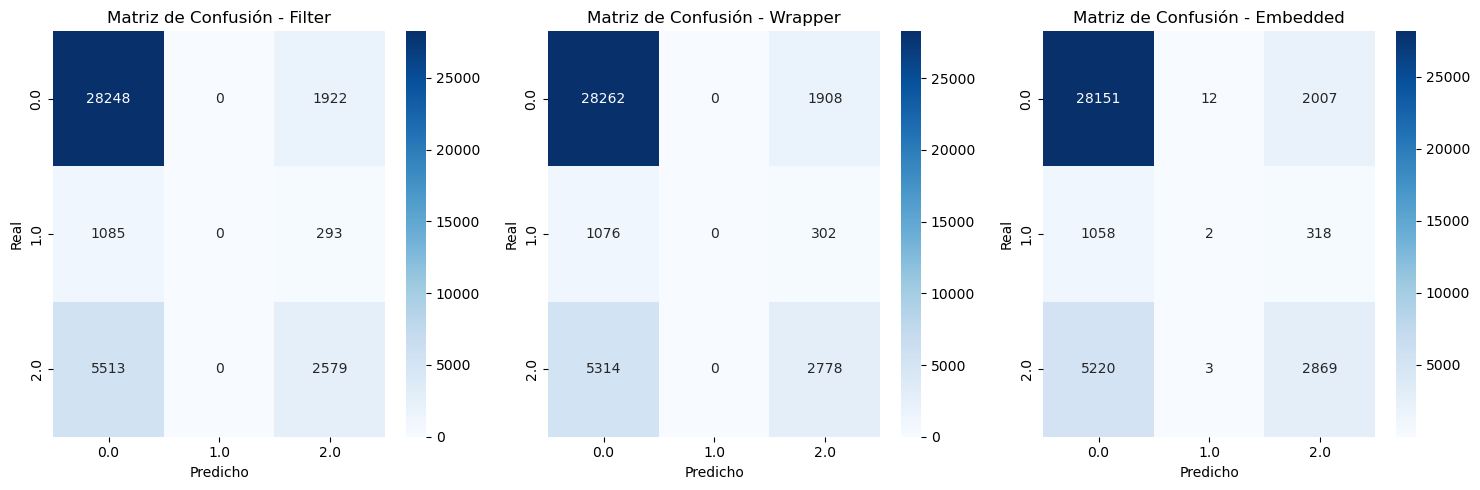

In [556]:
methods_results = {
    "Filter": (X_test_filter, features_filter, model_knn_filter),
    "Wrapper": (X_test_wrapper, features_wrapper, model_knn_wrapper),
    "Embedded": (X_test_embedded, features_embedded, model_lgb)  
}

metrics = evaluate_models(y_test, methods_results)

Se seleccionaron los siguientes métodos para evaluar la relevancia de las características en función de tres enfoques principales:

**Filter (Mutual Information):**
Seleccionamos 8 características relevantes: 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age' y  'Income'

**Wrapper (Sequential Forward Selection):**
Seleccioamosó 8 características:'HighBP','HighChol','CholCheck','BMI','HeartDiseaseorAttack', 'HvyAlcoholConsump' 'GenHlth y  'Ag'
.****Embedded (Árbol de decisión):*

Selecciamosn8 4 característic: 'MentHlth', 'PhysHlth', 'HighChol', 'Income', 'Age', 'BMI', 'GenHlth' y  'HighBP

Podemos ver que las características elegidas han sido muy similares. Tenemos 5 características en común en todos los métodos: 

    - HighBP
    - HighChol
    - BMI
    - Age
    - GenHlth

Por tanto, podemos decir que esas características son determinates en la diabetes. Tiene sentido porque todas están relacionadas con síntomas y factores de riesgo como alto colesterol, el BMI y una salud general.

En cuanto a las prestaciones, el método embedded es el que resultados en las métricas ha obtenido. Ha sido superior en todas:
- Accuracy=0.782593 
- ROC-AUC=0.805368  
- F1-Score=0.751608

Además, en su matriz de confusión podemos ver que es el primer modelo que clasifica bien a algún paciente prediabético. Por, tanto podemos concluir que es nuestro mejor método de selección de características.]).

## **e) Método ensemble**
Considere un esquema ensemble como Random Forest o Gradient Boosting para abordar la
tarea considerada.
- Explique intuitivamente el funcionamiento del método elegido, así como el hiper-parámetro a considerar.

Hemos elegido **Gradient Boosting**, que utiliza un modelo secuencial en el que cada árbol se construye para corregir los errores (residuos) del árbol anterior. Es un enfoque de boosting, donde los árboles no son independientes y se entrenan de manera sucesiva, con cada árbol tratando de mejorar el modelo global.
La decisión ha sido determinada porque queremos un modelo más preciso para intentar mejorar a los ya entrenados y conseguir clasificar bien algun paciente prediabético.

- Los hiperparámetros más importantes son:

    - n_estimators: Número de árboles en el modelo. Más árboles pueden mejorar el rendimiento hasta un punto, pero aumentan el riesgo de sobreajuste.
    - learning_rate: Tasa de aprendizaje que controla cuánto contribuye cada árbol al modelo final. Un valor más bajo generalmente requiere más árboles.
    - max_depth: Profundidad máxima de los árboles. Limitarla ayuda a evitar el sobreajuste.
    - subsample: Proporción de muestras utilizada para entrenar cada árbol, lo que introduce aleatoriedad y mejora la generalización.

- Resuelva la tarea considerando un valor adecuado del hiper-parámetro y evalúe las
prestaciones del modelo sobre el conjunto de test, obteniendo las mismas 4 figuras de
mérito anteriores. Comente los resultados obtenidos.

Vamos a elegir el parametro learning rate, el parámetro learning_rate controla cuánto contribuye cada nuevo árbol en un modelo de Gradient Boosting.

In [ ]:
# GridSearch para optimizar hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

n_grid=param_grid['learning_rate']

grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                           param_grid=param_grid, 
                           scoring='roc_auc_ovr', 
                           cv=3, 
                           n_jobs=-1,
                           return_train_score=True)

# Medimos el tiempo de ejecución
start_time = time.time()                                     # Tiempo de inicio

# Entrenamiento del GridSearch con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Tiempo de finalización
end_time = time.time()  

# Calculamos y mostramos el tiempo total
execution_time = (end_time - start_time)/60
print(f"Tiempo de ejecución del clasificador k-NN: {execution_time:.4f} minutos")

# Mejor modelo encontrado
best_model = grid_search.best_estimator_
print(f"\nMejor valor del parámetros: {grid_search.best_params_}")

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)
y_pred_best_proba = best_model.predict_proba(X_test)

auc_knn_train = np.array(grid_search.cv_results_['mean_train_score'])  # AUC promedio en el conjunto de entrenamiento.
auc_knn_val = np.array(grid_search.cv_results_['mean_test_score'])     # AUC promedio en el conjunto de validación.


# Cálculo de métricas para el mejor modelo
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='weighted',zero_division=1)
recall_best = recall_score(y_test, y_pred_best, average='weighted')
f1_best = f1_score(y_test, y_pred_best, average='weighted')
roc_auc_best = roc_auc_score(y_test, y_pred_best_proba, multi_class='ovr', average='weighted')

print(f"\n Mejor Modelo {grid_search.best_params_}")
print(f"Accuracy: {accuracy_best:.2f}")
print(f"F1-Score: {f1_best:.2f}")
print(f"ROC-AUC: {roc_auc_best:.2f}")

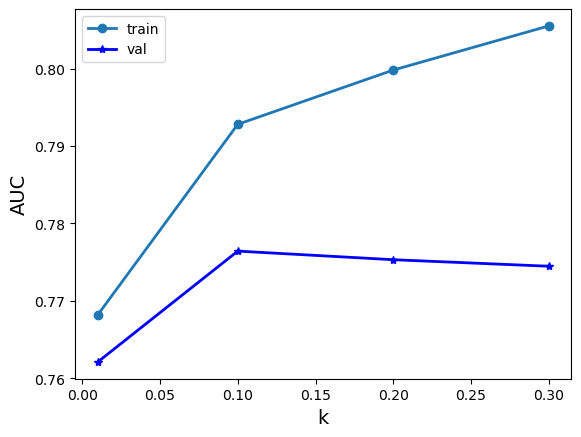

In [592]:
# Graficamos las curvas de AUC en función de k para entrenamiento y validación
plt.plot(n_grid, auc_knn_train, '-o', label="train", linewidth=2)          # Curva para AUC de entrenamiento.
plt.plot(n_grid, auc_knn_val, '-*b', label="val", linewidth=2)             # Curva para AUC de validación.
plt.xlabel('k', fontsize=14)  
plt.ylabel('AUC', fontsize=14)   
plt.legend()  
plt.show()                                                                 

Podemos observar como el modelo de Gradient Boosting rapidamente sobreajusta y empeora el rendimiento en validación.

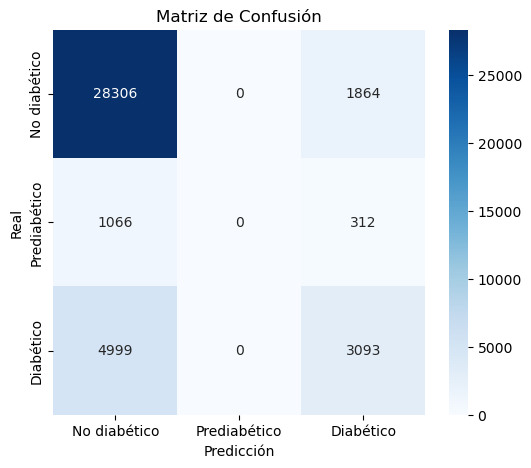

In [593]:
# Visualización de la matriz de confusión 
conf_matrix= confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=datanames, yticklabels=datanames)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

## **f) Comparación de los resultados obtenidos con los modelos diseñados en los apartados anteriores**
- Proporcione en una tabla con los valores obtenidos para las 4 figuras de mérito sobre el
conjunto de test. Comente y justifique los resultados.
- De los indicados en este Tema del Proyecto 2, justifique razonadamente qué esquema y
conjunto de características elegiría.

### Comparación de Resultados en el Conjunto de Test
A continuación se presenta la tabla con los valores obtenidos para las figuras de mérito **ROC-AUC**, **Accuracy** y **F1-Score** de los modelos entrenados y evaluados:

| Modelo              | ROC-AUC | Accuracy | F1-Score |
|---------------------|---------|----------------------|---------|
| K-NN (k=30)         | 0.739   | 0.773              | 0.734   |
| Árbol (max depth =6) | 0.756  | 0.786               | 0.751    |
| Árbol (min samples leaf=51) | *0.74* | 0.7           | 0.435    |
| MLP                 | 0.779   | 0.75                | 0.762    |
| Gradient Boosting   | **0.8**    | **0.78**                 | **0.75**     |


### Comentarios y Justificación de los Resultados

**K-NN (k=30):**

ROC-AUC de 0.739, lo que sugiere un desempeño moderado en cuanto a la capacidad del modelo para distinguir entre clases.
La accuracy de 0.773 es razonablemente buena, lo que implica que el modelo tiene un buen desempeño general.
F1-Score de 0.734 refleja un equilibrio entre precisión y recall, pero no es tan alto como el de otros modelos.

**Árbol (max depth = 6):**

Un ROC-AUC de 0.756 indica una mejora en la capacidad del modelo para diferenciar entre las clases, superando al K-NN.
La accuracy de 0.786 es ligeramente mejor que la de K-NN, lo que sugiere un mejor rendimiento global.
El F1-Score de 0.751 indica un buen equilibrio entre precisión y recall, superior al de K-NN.

**Árbol (min samples leaf = 51):**

ROC-AUC de 0.74 es más bajo que los modelos anteriores, lo que sugiere que este árbol tiene una menor capacidad para distinguir entre las clases.
La accuracy es de 0.7, lo que es considerablemente más bajo en comparación con los otros modelos.
El F1-Score de 0.435 es bajo, lo que refleja una combinación deficiente entre precisión y recall.

**MLP (Perceptrón Multicapa):**

ROC-AUC de 0.779, lo que indica una capacidad sólida para diferenciar entre las clases.
La accuracy es de 0.75, lo que muestra un buen rendimiento general.
El F1-Score de 0.762 indica un buen equilibrio entre precisión y recall, superior al de K-NN y árboles.

**Gradient Boosting:**

El ROC-AUC más alto (0.8) sugiere que el modelo tiene la mejor capacidad para distinguir entre las clases.
La accuracy de 0.78 es la mejor entre todos los modelos, lo que refleja un excelente rendimiento en la clasificación de ambas clases.
El F1-Score de 0.75 es también el más alto, demostrando un equilibrio destacado entre precisión y recall.

### Elección del Modelo y Conjunto de Características

En base a los resultados obtenidos, el **Gradient Boosting** es el modelo que muestra el mejor desempeño global, con el **ROC-AUC** más alto (0.8), lo que sugiere que es el mejor modelo para la tarea de clasificación. Este modelo también tiene un **accuracy** alto lo que indica que no solo es bueno para separar las clases, sino también para identificar correctamente las instancias positivas y negativas.

Sin embargo, solo filtrando las características con un filtro embedded conseguimos clasificar pacientes prediabéticos. Aplicar por tanto el Gradient Boosting después de este filtrado sería interesante.

- Explique detallada y razonadamente el procedimiento a seguir para obtener
estadísticos de cada una de las figuras de mérito (por ejemplo, media y desviación
típica

In [590]:
# Definimos el modelo
model = GradientBoostingClassifier()

# Validación cruzada para calcular el ROC-AUC
roc_auc_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc_ovr', cv=3)
print(f"ROC-AUC media: {np.mean(roc_auc_scores):.3f}")
print(f"Desviación típica ROC-AUC: {np.std(roc_auc_scores):.3f}")

# Validación cruzada para calcular Accuracy
accuracy_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=3)
print(f"Accuracy media: {np.mean(accuracy_scores):.3f}")
print(f"Desviación típica Accuracy: {np.std(accuracy_scores):.3f}")

# Validación cruzada para calcular F1-Score
f1_scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=3)
print(f"F1-Score media: {np.mean(f1_scores):.3f}")
print(f"Desviación típica F1-Score: {np.std(f1_scores):.3f}")

# Validación cruzada para calcular Recall
recall_scores = cross_val_score(model, X_train, y_train, scoring='recall_weighted', cv=3)
print(f"Recall media: {np.mean(recall_scores):.3f}")
print(f"Desviación típica Recall: {np.std(recall_scores):.3f}")

ROC-AUC media: 0.778
Desviación típica ROC-AUC: 0.003
Accuracy media: 0.785
Desviación típica Accuracy: 0.003
F1-Score media: 0.755
Desviación típica F1-Score: 0.003
Recall media: 0.785
Desviación típica Recall: 0.003


Las métricas:
- cross_val_score: Permite realizar validación cruzada y obtener las métricas de rendimiento para cada partición del conjunto de datos.
- scoring: Especifica la métrica a evaluar, como roc_auc, accuracy, f1_weighted o recall_weighted.
- np.mean y np.std: Calculan la media y la desviación estándar de las puntuaciones obtenidas, proporcionando una estimación del rendimiento y su     variabilidad.

# **Tema 5 – Aprendizaje no Supervisado** 


En caso de que el conjunto de observaciones esté asociado a una tarea de clasificación o regresión,
en la primera fase de esta parte del proyecto se prescindirá de la variable o variables asociadas a
la salida deseada (target), a fin de abordar una tarea de aprendizaje no supervisado.
Se propone hacer uso de las dos técnicas de aprendizaje no supervisado presentadas en la asignatura:
el esquema particional denominado k-medias y el esquema de agrupamiento jerárquico
aglomerativo. Para abordar esta tarea, haga uso del mismo conjunto de características (sin aplicar
selección de características) que las utilizadas como entrada al abordar la parte del proyecto asociada
al Tema 4.

a) Aplique el algoritmo de agrupamiento k-medias con distintos valores de k-medias. 
- Justifique la elección de una figura de mérito y obtenga su valor cuando explora distintos
valores de k. Haciendo uso de estos valores, justifique razonadamente el número de
grupos más adecuado (de entre los explorados).


Vamos a utilizar la silueta.
El Silhouette Score mide qué tan bien están agrupados los puntos dentro de sus clusters en comparación con otros clusters. Además, es fácil de interpretar, nos ayuda a identificar el número óptimo de clusters y es compatible con los objetivos del k-medias, maximizando la calidad del agrupamiento.

Varía entre -1 y 1:
- Cerca de 1 → Buen clustering.La distancia promedio entre una muestra y los puntos de su propio cluster es mucho menor que la distancia promedio a los puntos del cluster más cercano.
- Cerca de 0 → Punto en el borde de dos clusters. Puede ser señal de clusters que se solapan o no están bien definidos.
- Negativo → Indica que las muestras están asignadas al cluster incorrecto.

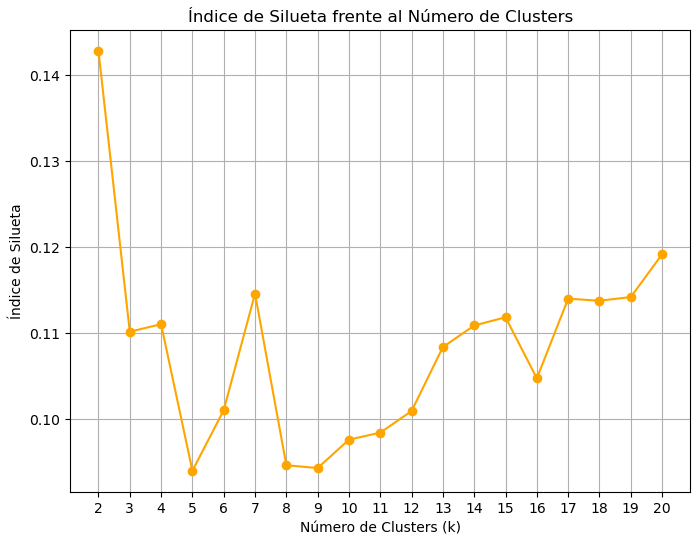

El mejor número de clusters según Silhouette Score es: 2


In [15]:
# Definimos el rango de valores de k
range_k = range(2, 21)  # Probaremos con valores de k entre 2 y 20

# Lista para guardar los valores del índice de silueta
silhouette_scores = []

# Tomamos una muestra representativa del conjunto de datos, por problemas de memoria.
X_train_sample, _ = train_test_split(X_train, train_size=0.25, random_state=42)

# Probamos distintos valores de k
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_sample)  # Aplicamos el KMeans
    score = silhouette_score(X_train_sample, cluster_labels)    # Calculamos el índice de silueta
    silhouette_scores.append(score)

# Graficar el índice de silueta frente al número de clusters
plt.figure(figsize=(8, 6))
plt.plot(range_k, silhouette_scores, marker='o', color='orange')
plt.title('Índice de Silueta frente al Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Índice de Silueta')
plt.xticks(range_k)
plt.grid(True)
plt.show()

# Mejor valor de k
best_k = range_k[np.argmax(silhouette_scores)]
print(f"El mejor número de clusters según Silhouette Score es: {best_k}")

El método nos indique es mejor coger k=2. Tiene sentido dado que en la experimentalidad se ha visto que todos los modelos tienden a ignorar una clase (Prediabéticos). Sin embargo,vamos elegir k=7, debido a que su índice de silueta es similar, y tiene un repunte muy claro con los valores de k de su alrededor. Además, valores mucho más altos no se ajustarían al contexto de nuestra base de datos.

Para n_clusters = 7 , el valor medio de la silueta es: 0.11460727125832887


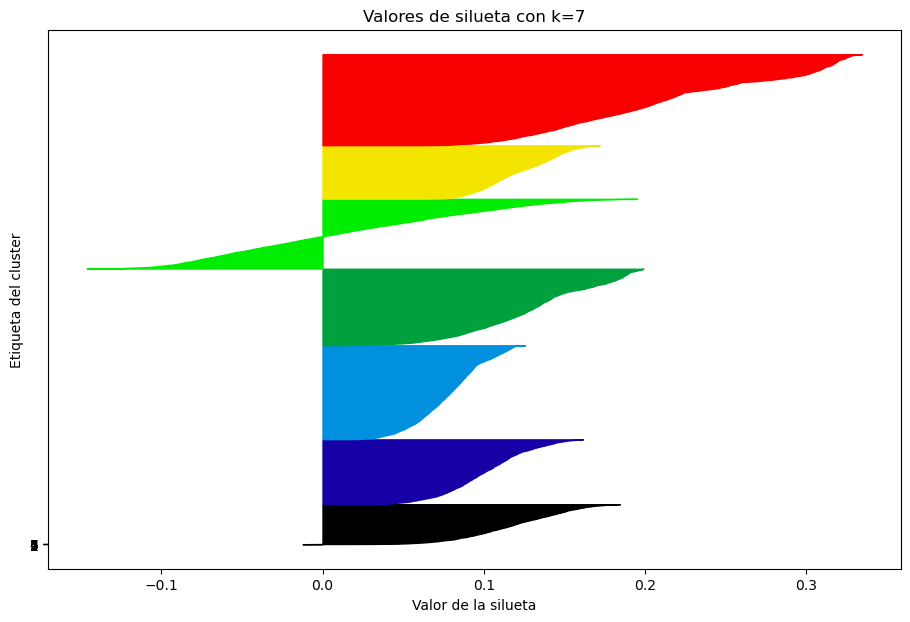

In [28]:
# Ejecutamos el algoritmo KMeans con k=10
kmeans_2 = KMeans(n_clusters=7, random_state=42)
etiquetas2 = kmeans_2.fit_predict(X_train_sample)  # Usamos X_train_sample

# Calculamos el índice de silueta promedio
silhouette_avg = silhouette_score(X_train_sample, etiquetas2)
print("Para n_clusters =", 7, ", el valor medio de la silueta es:", silhouette_avg)

# Obtenemos el valor de la silueta para cada observación
sample_silhouette_values = silhouette_samples(X_train_sample, etiquetas2)

# Graficamos los valores de la silueta para cada cluster
plt.figure(figsize=(11, 7))

y_lower = 10
n_clusters = 7
for i in range(n_clusters):
    # Consideramos los valores de silueta de un único cluster
    ith_cluster_silhouette_values = sample_silhouette_values[etiquetas2 == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Usamos una paleta de colores diferente para cada cluster
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color)

    # Actualizamos el valor de y_lower para la siguiente representación
    y_lower = y_upper + 10

# Personalización de la gráfica
plt.xlabel('Valor de la silueta')
plt.ylabel('Etiqueta del cluster')
plt.title('Valores de silueta con k=7')
plt.yticks([1, 2, 3, 4, 5, 6, 7])    # Se añade para ajustar los ticks del eje Y
plt.show()

Se peude observar que en casi todos los cluster el valor de la silueta es positivo, pero no muy grande. Esto significa que no hay una gran diferenciación entre los cluster. En el quinto cluster, hay valores de silueta negativos, indicando que la distancia a su propio cluster es mayor que la distancia al cluster más cercano, por lo tanto puede no estar asignado correctamente.
En general, no se ha obtenido un buen resultado.

- Explique si ha considerado necesario aplicar alguna etapa de pre-procesamiento a las
características. En caso afirmativo, justifique su uso.

    El preprocesamiento es un paso fundamental en el algoritmo de K-Medias, ya que puede influir significativamente en la calidad de los grupos obtenidos. En nuestro caso, han sido fundamentales:

    - La normalización o escalado de los datos.El algoritmo de k-medias utiliza medidas de distancia, por lo que si las variables tienen escalas muy diferentes, las características con mayor escala dominarán el cálculo de las distancias y, en consecuencia, el algoritmo podría agrupar de forma errónea.En nuestro caso, ya hicimos la normalización el el proyecto anterior, por lo que no ha hecho falta.

    - También hemos tenido que hacer un submuestreo de los datos, debido a que utilizamos al caqlcular distancias,tenemos que guardar matrices muy grandes que dan problema de memoria.

b) Aplique el algoritmo de agrupamiento jerárquico aglomerativo

- Utilice, al menos, 3 opciones de linkage diferentes. Analice los tres dendrogramas
(realizando comentarios) y justifique el tipo de linkage más adecuado. Considerando
únicamente el dendrograma asociado al tipo de linkage que considera más adecuado,
¿qué número de grupos k_hc considera razonable utilizar para su conjunto de
observaciones? Justifique su respuesta.

    Hemos elegido los métodos Single Linkage, Complete Linkage y Centroid Linkage. Son técnicas utilizadas en el algoritmo de agrupamiento jerárquico, que construye un árbol (dendrograma) para representar las relaciones entre los datos. Estas técnicas definen cómo se calcula la "distancia" entre dos grupos (o clusters).

    - El Single Linkage calcula la distancia entre dos grupos como la distancia mínima entre cualquier par de puntos, uno en cada grupo. Es decir, la distancia entre dos clusters es igual a la distancia más corta entre un punto de un cluster y un punto del otro cluster.

    - El Complete Linkage calcula la distancia entre dos grupos como la distancia máxima entre cualquier par de puntos, uno en cada grupo. Es decir, la distancia entre dos clusters es igual a la distancia más larga entre un punto de un cluster y un punto del otro cluster.

    - El Centroid Linkage calcula la distancia entre dos grupos como la distancia entre los centros de masa (centroides) de los dos clusters. El centroide de un grupo se define como el promedio de las coordenadas de los puntos dentro de ese grupo.

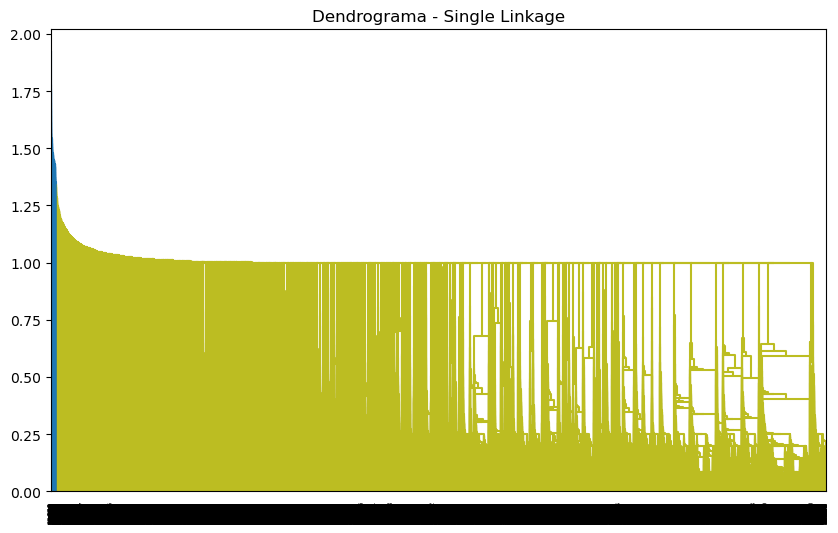

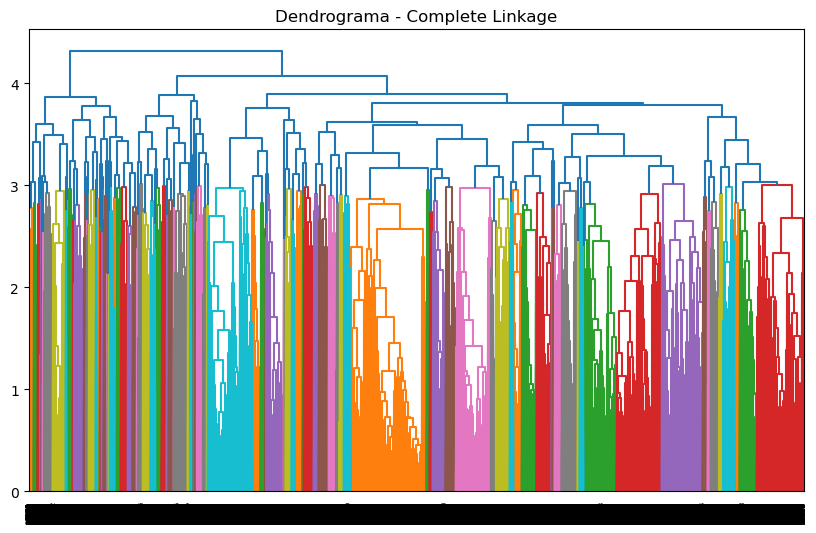

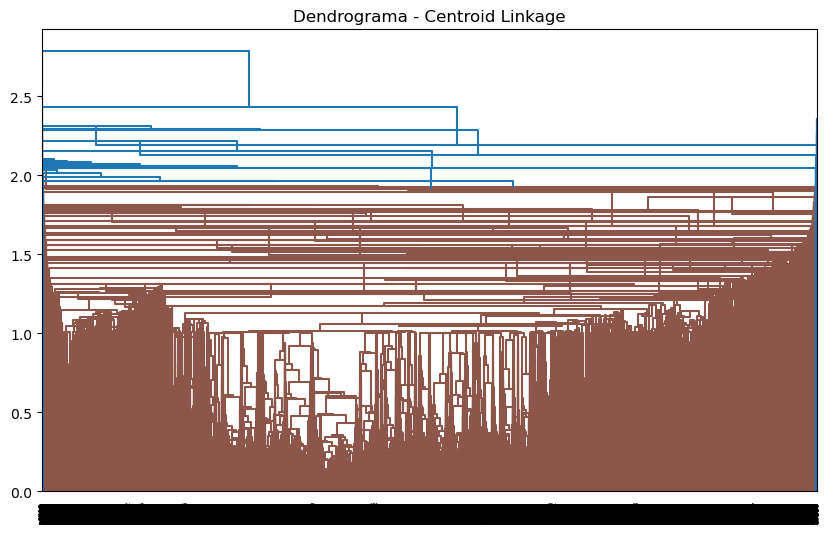

In [30]:
# Single linkage
Z_single = linkage(X_train_sample, method='single')

# Graficamos el dendrograma para Single linkage
plt.figure(figsize=(10, 6))
dendrogram(Z_single)
plt.title('Dendrograma - Single Linkage')
plt.show()

# Complete linkage
Z_complete = linkage(X_train_sample, method='complete')

# Graficamos el dendrograma para Complete linkage
plt.figure(figsize=(10, 6))
dendrogram(Z_complete)
plt.title('Dendrograma - Complete Linkage')
plt.show()

# Centroid linkage
Z_centroid = linkage(X_train_sample, method='centroid')

# Graficamos el dendrograma para Centroid linkage
plt.figure(figsize=(10, 6))
dendrogram(Z_centroid)
plt.title('Dendrograma - Centroid Linkage')
plt.show()

- Comparación de los métodos:
    - **Single Linkage:** Genera clústeres alargados o con formas irregulares.
    - **Complete Linkage:** Prefiere clústeres compactos y bien definidos, separando mejor los grupos.
    - **Centroid Linkage:** Busca un equilibrio, considerando la media de los puntos, pero puede ser más sensible a outliers.

La elección del método más adecuado corresponde con el complete linkage, ya que se forman clusters compactos y bien diferenciados a diferencia de los otros dos métodos.

- Haciendo uso ahora de la misma figura de mérito que la considerada en el apartado a)
de la parte del proyecto asociada al Tema 5, obtenga los valores de esa figura de mérito
para un rango de número de grupos centrado en el valor de k_hc. Justifique
razonadamente si el resultado obtenido avala la elección del número de grupos realizada
en el primer párrafo del apartado b) (i.e, k_hc).

Al analizar el dendrograma generado con el método de Complete Linkage, se puede identificar el punto en el que la distancia entre las fusiones de los clusters aumenta considerablemente. Este punto, conocido como la altura de corte, nos indica una gran diferencia entre la similitud de los clusters que se están fusionando en ese momento, lo que puede sugerir un número óptimo de clusters.

Hemos seleccionado k_hc = 5 porque, visualmente, podemos observar un cambio significativo en la estructura de los clusters. Después de este punto de corte, las fusiones ocurren a distancias mucho mayores, lo que indica que los clusters fusionados previamente eran más similares entre sí. Este punto de inflexión es una indicación de que seis clusters es el número adecuado para dividir el conjunto de datos, ya que más allá de este punto, las fusiones corresponden a grupos más distantes y menos similares.

Este resultado es similar al obtenido con el algoritmo k-medias.

Tomaremos k_hc = 5 ya que visualmente, observamos buena división y cambio en los clusters del dendrograma.

- **Figura de mérito**: Usaremos el **coeficiente de silueta** como en el apartado a), ya que mide la coherencia de las observaciones dentro de sus clústeres y la separación entre ellos.
- **Número de grupos (k_hc)**: En el paso previo, identificamos el valor de k_hc, que será el punto central del rango de grupos a evaluar. Consideraremos un rango razonable alrededor de este valor
- **Justificación del valor**: Calcularemos el coeficiente de silueta para cada valor de k en el rango y observaremos si el k_hc seleccionado proporciona un valor cercano al óptimo.

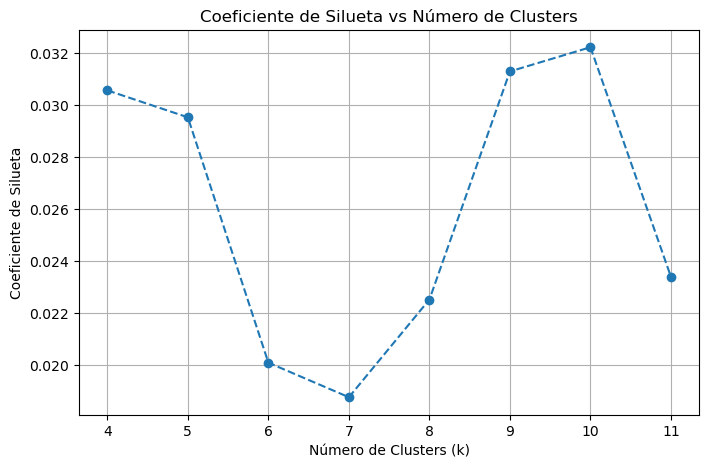

In [33]:
k_hc = 5

# Rango de valores de k
k_values = range(k_hc - 1, k_hc + 6)

# Lista para guardar los valores de silueta
silhouette_scores = []

# Calcular coeficiente de silueta para cada k
for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = clustering.fit_predict(X_train_sample)
    silhouette_scores.append(silhouette_score(X_train_sample, labels))

# Gráfica de los valores de silueta
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Coeficiente de Silueta vs Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.grid()
plt.show()

Se puede observar como el valor elegido k=5 no está lejos de ser el mejor valor de silueta. Cabe destacar también los bajos valores del coeficiente de silueta.

- Explique si ha considerado necesario aplicar alguna etapa de pre-procesamiento a las
características. En caso afirmativo, justifique su uso.

A parte de las etapas ya hechas en el preprocesado de los datos, lo único que se ha tenido que añadir es un submuestreo de los datos debido a la gran coste computacional que tienen estos métodos. Nos ha dado problemas de memoria y de tiempo, asi que hemos cogido un 25% de todas las muestras. Como ha sido proporcional, no hemos perdido mucha información.

c) Si compara los resultados obtenidos en los apartados a) y b), justifique razonadamente la
elección del número de grupos y de la técnica de agrupamiento (particional,
jerárquico) que considera más adecuada. Considerando esta elección, obtenga el
“patrón” que caracteriza cada grupo e intente interpretarlo (en la medida de lo posible).
El “patrón” que caracteriza un determinado grupo se puede obtener como un vector de las
mismas características que las observaciones. El valor de cada característica del “patrón” se
obtiene como el promedio de los valores de esa característica para las observaciones
asociadas al grupo que se analiza. 

El "patrón" que define un grupo específico se puede representar como un vector con las mismas características que las observaciones. El valor de cada característica en este patrón se obtiene calculando el promedio de los valores de esa característica para todas las observaciones que pertenecen al grupo en cuestión.

**Comparación de las técnicas de agrupamiento (k-medias vs. jerárquico):** 


**Robustez:**

K-medias es sensible a los valores iniciales de los centroides debido a su naturaleza basada en la optimización iterativa. Si se eligen inicializaciones subóptimas de los centroides (lo que depende del valor de random_state), el algoritmo puede converger en un óptimo local y no encontrar la mejor solución global. Para mitigar este problema, se utilizan técnicas como el K-means++, que mejora la selección inicial de los centroides, pero la sensibilidad a los valores iniciales sigue siendo una consideración importante.

En cambio, el agrupamiento jerárquico es un proceso determinista, lo que significa que no depende de inicializaciones aleatorias. La construcción de los clústeres se realiza de forma secuencial y sigue un criterio predefinido de proximidad (como el enlace completo, simple, o promedio). Este tipo de agrupamiento no requiere un valor inicial, ya que las fusiones de los clústeres se hacen en función de las distancias entre ellos, lo que da lugar a un dendrograma que muestra visualmente la jerarquía de las agrupaciones. Esto proporciona una visión más clara de las relaciones entre los grupos en diferentes niveles de granularidad.

**Estructura de los clústeres:**

K-medias supone que los clústeres son esféricos y equitativos en tamaño, lo que implica que cada clúster tiene aproximadamente la misma forma y densidad. Esto puede ser una limitación en situaciones donde los datos presentan una estructura más compleja, como clústeres de formas alargadas, no convexas o con densidades variables. En estos casos, el rendimiento de k-medias puede verse afectado, ya que este algoritmo tiende a forzar una división homogénea que no siempre refleja la estructura real de los datos.

Por otro lado, complete linkage en el agrupamiento jerárquico no impone restricciones sobre la forma de los clústeres y es capaz de identificar agrupamientos compactos, sin importar la forma específica que adopten. Este enfoque puede ser más adecuado cuando los datos contienen clústeres de diferentes formas o densidades, ya que tiene en cuenta las distancias máximas entre los puntos de los clústeres y tiende a fusionar los grupos de manera que se maximiza la cohesión interna. Así, complete linkage puede ofrecer una mayor flexibilidad y un mejor rendimiento en situaciones donde los clústeres no sean esféricos ni equitativos en tamaño.

**Número de grupos:**

En el caso de k-medias, el valor óptimo de k=7 se determinó utilizando el índice de silueta, lo que sugiere que este número de clusters proporciona la mejor separación entre los grupos según esta métrica.

Sin embargo, al aplicar el agrupamiento jerárquico con el método complete linkage, el número de clusters khc=7 mostró el peor rendimiento, lo que indica que, aunque visualmente podría parecer una opción razonable, el rendimiento en términos de calidad del agrupamiento no fue tan bueno como en otros valores de k. Esto podría deberse a la naturaleza del algoritmo jerárquico y cómo maneja la distancia entre clusters, especialmente con un número más elevado de ellos.

